In [1]:
import utils
import numpy as np
from tensorflow.keras.models import load_model 
from scipy.stats import entropy


2023-10-06 07:56:42.447825: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-06 07:56:42.474566: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-06 07:56:42.474593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-06 07:56:42.474613: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-06 07:56:42.479538: I tensorflow/core/platform/cpu_feature_g

Train baseline models. These will be the reference points to evaluate our solution.

First let's train on the train data as a baseline. 

In [2]:
# Create a new model
model = utils.get_kaggle_model()
model_name = 'baseline_model_trained_on_init_data'

# Load given data
data = utils.get_data()

train_x, train_y = data['train']
prep_train_x, prep_train_y = utils.prepare_data(train_x, train_y)

test_x, test_y = data['test']
prep_test_x, prep_test_y = utils.prepare_data(test_x, test_y)

# We use early stopping, monitoring val_accuracy with the patience of 8
model, history = utils.train_model(model, model_name, prep_train_x,prep_train_y,prep_test_x, prep_test_y,epochs=100, batch_size=64,verbose=1)

print(utils.model_stats(model, prep_test_x, test_y))
utils.save_model(f'{model_name}.keras', model)
utils.save_history(model_name,history)



2023-10-06 07:56:43.607340: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-06 07:56:43.611252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-06 07:56:43.611364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


2023-10-06 07:56:45.324659: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-06 07:56:46.174866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-06 07:56:47.465910: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f55b46eb170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-06 07:56:47.465926: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-10-06 07:56:47.469401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-06 07:56:47.531083: I ./tensorflow/compiler/jit/device_compiler.

16/16 [==============================] - 6s 84ms/step - loss: 3.0772 - accuracy: 0.1440 - val_loss: 2.3375 - val_accuracy: 0.1000
Epoch 2/100
16/16 [==============================] - 0s 31ms/step - loss: 2.6665 - accuracy: 0.2240 - val_loss: 2.4387 - val_accuracy: 0.1000
Epoch 3/100
16/16 [==============================] - 0s 31ms/step - loss: 2.5160 - accuracy: 0.2310 - val_loss: 2.6612 - val_accuracy: 0.1000
Epoch 4/100
16/16 [==============================] - 0s 32ms/step - loss: 2.3437 - accuracy: 0.2480 - val_loss: 2.8354 - val_accuracy: 0.1001
Epoch 5/100
16/16 [==============================] - 0s 31ms/step - loss: 2.0480 - accuracy: 0.3070 - val_loss: 2.9242 - val_accuracy: 0.1000
Epoch 6/100
16/16 [==============================] - 0s 30ms/step - loss: 1.9132 - accuracy: 0.3430 - val_loss: 3.2677 - val_accuracy: 0.1000
Epoch 7/100
16/16 [==============================] - 0s 32ms/step - loss: 1.9364 - accuracy: 0.3230 - val_loss: 3.2481 - val_accuracy: 0.1010
Epoch 8/100
16/16 

Train on the whole dataset (initial train plus data pool). 

In [3]:
model = utils.get_kaggle_model()
model_name = 'baseline_model_trained_on_all'

data = utils.get_data()

train_x, train_y = data['train']
pool_x, pool_y = data['pool']
train_x += pool_x
train_y += pool_y

utils.print_class_counts(train_y)

prep_train_x, prep_train_y = utils.prepare_data(train_x, train_y)

test_x, test_y = data['test']
prep_test_x, prep_test_y = utils.prepare_data(test_x, test_y)

model, history = utils.train_model(model, model_name, prep_train_x,prep_train_y,prep_test_x, prep_test_y,epochs=100, batch_size=64,verbose=1)

print(utils.model_stats(model, prep_test_x, test_y))
utils.save_model(f'{model_name}.keras', model)
utils.save_history(model_name,history)


[5000, 5000, 5000, 472, 5000, 5000, 5000, 535, 5000, 453]
Epoch 1/100
570/570 [==============================] - 7s 9ms/step - loss: 2.0718 - accuracy: 0.3003 - val_loss: 1.7728 - val_accuracy: 0.3694
Epoch 2/100
570/570 [==============================] - 5s 8ms/step - loss: 1.5521 - accuracy: 0.4327 - val_loss: 1.3300 - val_accuracy: 0.5176
Epoch 3/100
570/570 [==============================] - 4s 8ms/step - loss: 1.3559 - accuracy: 0.5063 - val_loss: 1.3972 - val_accuracy: 0.5152
Epoch 4/100
570/570 [==============================] - 5s 8ms/step - loss: 1.2333 - accuracy: 0.5574 - val_loss: 1.1628 - val_accuracy: 0.5890
Epoch 5/100
570/570 [==============================] - 4s 8ms/step - loss: 1.1262 - accuracy: 0.5983 - val_loss: 1.3266 - val_accuracy: 0.5678
Epoch 6/100
570/570 [==============================] - 5s 8ms/step - loss: 1.0668 - accuracy: 0.6201 - val_loss: 0.9915 - val_accuracy: 0.6499
Epoch 7/100
570/570 [==============================] - 5s 8ms/step - loss: 0.9932 - 

To utilize the pool data set most, predict them with the baseline model trained on initial training data. Focus on the ones where model is wrong. From them choose the ones where the entropy is the lowest and so they are sure about their (wrong) decision. 

In [4]:
model_name = 'baseline_model_trained_misclassed_worstclass_lowentropy'
data = utils.get_data()

train_x, train_y = data['train']
prep_train_x, prep_train_y = utils.prepare_data(train_x, train_y)

test_x, test_y = data['test']
prep_test_x, prep_test_y = utils.prepare_data(test_x, test_y)

pool_x, pool_y = data['pool']
prep_pool_x, prep_pool_y = utils.prepare_data(pool_x, pool_y)

model= load_model('baseline_model_trained_on_init.keras')

new_train_x = prep_train_x.copy()
new_train_y = prep_train_y.copy()

flag_batch_size = 100
total_flag_size = 1000
misclassed = []
min_misclassed = len(pool_y)
for i in range(int(total_flag_size/flag_batch_size)):
    pred_probs_y = model.predict(prep_pool_x)
    
    pred_pool_y = [np.argmax(x) for x in pred_probs_y]
    stats = utils.model_stats(model,prep_pool_x,np.argmax(prep_pool_y, axis=1))
    worst_class = np.argmin(stats['categorical_accuracy_scores'])
    
    misclassed_count = len(np.where((np.argmax(prep_pool_y, axis=1)!=np.array(pred_pool_y)))[0])
    
    misclassified_indexes = np.where((np.argmax(prep_pool_y, axis=1)!=np.array(pred_pool_y)) & (np.argmax(prep_pool_y, axis=1)==worst_class))[0]

    print(f'Round {i}, Nr of misclassed', misclassed_count)
    misclassed.append(misclassed_count)
    
    if len(misclassified_indexes)> flag_batch_size:
        selected_indexes = []
        
        # select misclassified samples with the lowest entropy, since these are the worst cases\n",
        entropies = entropy(pred_probs_y, axis=1)
        argsorted_entrop = np.argsort(entropies)

        for index in argsorted_entrop:
            if index in misclassified_indexes:
                selected_indexes.append(index)
        selected_indexes = np.array(selected_indexes)[:flag_batch_size]
    else:
        selected_indexes = misclassified_indexes

    new_train_x = np.vstack((new_train_x, prep_pool_x[selected_indexes]))
    new_train_y = np.vstack((new_train_y, prep_pool_y[selected_indexes]))

    prep_pool_x = np.delete(prep_pool_x, selected_indexes, axis=0)
    prep_pool_y = np.delete(prep_pool_y, selected_indexes, axis=0)

    model = utils.get_kaggle_model()
    model, history = utils.train_model(model, model_name, new_train_x,new_train_y,prep_test_x, prep_test_y,epochs=65, batch_size=64,verbose=1)
    

print(utils.model_stats(model, prep_test_x, test_y))
print('Class_counts: ', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])
utils.save_model(f'{model_name}.keras', model)
history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]
utils.save_history(model_name,history)


1109/1109 [==============================] - 2s 1ms/step
Round 0, Nr of misclassed 15030
Epoch 1/65


2023-10-06 08:01:52.340836: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - 3s 66ms/step - loss: 3.3495 - accuracy: 0.1391 - val_loss: 2.3705 - val_accuracy: 0.1000
Epoch 2/65
18/18 [==============================] - 0s 28ms/step - loss: 2.8256 - accuracy: 0.2236 - val_loss: 2.4898 - val_accuracy: 0.1000
Epoch 3/65
18/18 [==============================] - 0s 28ms/step - loss: 2.4729 - accuracy: 0.2645 - val_loss: 2.5615 - val_accuracy: 0.1000
Epoch 4/65
18/18 [==============================] - 1s 30ms/step - loss: 2.2824 - accuracy: 0.2591 - val_loss: 2.7617 - val_accuracy: 0.1098
Epoch 5/65
18/18 [==============================] - 0s 28ms/step - loss: 2.1080 - accuracy: 0.2991 - val_loss: 3.1455 - val_accuracy: 0.1000
Epoch 6/65
18/18 [==============================] - 1s 29ms/step - loss: 1.9882 - accuracy: 0.3073 - val_loss: 3.5955 - val_accuracy: 0.1119
Epoch 7/65
18/18 [==============================] - 0s 28ms/step - loss: 1.8865 - accuracy: 0.3336 - val_loss: 3.6447 - val_accuracy: 0.1000
Epoch 8/65
18/18 [======

2023-10-06 08:03:10.460117: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 3s 58ms/step - loss: 3.2109 - accuracy: 0.1538 - val_loss: 2.3450 - val_accuracy: 0.1017
Epoch 2/65
21/21 [==============================] - 1s 25ms/step - loss: 2.5937 - accuracy: 0.2369 - val_loss: 2.4635 - val_accuracy: 0.1000
Epoch 3/65
21/21 [==============================] - 1s 25ms/step - loss: 2.3395 - accuracy: 0.2792 - val_loss: 2.7841 - val_accuracy: 0.1000
Epoch 4/65
21/21 [==============================] - 0s 25ms/step - loss: 2.1323 - accuracy: 0.3008 - val_loss: 2.8982 - val_accuracy: 0.1000
Epoch 5/65
21/21 [==============================] - 1s 26ms/step - loss: 1.9809 - accuracy: 0.3338 - val_loss: 3.2070 - val_accuracy: 0.1075
Epoch 6/65
21/21 [==============================] - 1s 25ms/step - loss: 1.8772 - accuracy: 0.3485 - val_loss: 3.3696 - val_accuracy: 0.1011
Epoch 7/65
21/21 [==============================] - 1s 25ms/step - loss: 1.8123 - accuracy: 0.3738 - val_loss: 3.8962 - val_accuracy: 0.1000
Epoch 8/65
21/21 [======

2023-10-06 08:04:30.870429: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 [==============================] - 3s 48ms/step - loss: 3.0200 - accuracy: 0.1747 - val_loss: 2.3780 - val_accuracy: 0.1000
Epoch 2/65
24/24 [==============================] - 1s 23ms/step - loss: 2.5034 - accuracy: 0.2460 - val_loss: 2.6535 - val_accuracy: 0.1000
Epoch 3/65
24/24 [==============================] - 1s 22ms/step - loss: 2.3068 - accuracy: 0.2800 - val_loss: 2.6519 - val_accuracy: 0.1000
Epoch 4/65
24/24 [==============================] - 1s 23ms/step - loss: 2.1430 - accuracy: 0.2893 - val_loss: 2.9199 - val_accuracy: 0.1001
Epoch 5/65
24/24 [==============================] - 1s 23ms/step - loss: 2.0309 - accuracy: 0.2967 - val_loss: 3.0226 - val_accuracy: 0.1039
Epoch 6/65
24/24 [==============================] - 1s 22ms/step - loss: 1.9392 - accuracy: 0.3107 - val_loss: 3.2172 - val_accuracy: 0.1000
Epoch 7/65
24/24 [==============================] - 1s 23ms/step - loss: 1.8151 - accuracy: 0.3493 - val_loss: 3.1540 - val_accuracy: 0.1093
Epoch 8/65
24/24 [======

2023-10-06 08:05:53.171322: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 3s 47ms/step - loss: 3.2170 - accuracy: 0.1535 - val_loss: 2.4846 - val_accuracy: 0.1151
Epoch 2/65
27/27 [==============================] - 1s 21ms/step - loss: 2.6253 - accuracy: 0.2035 - val_loss: 2.6928 - val_accuracy: 0.1059
Epoch 3/65
27/27 [==============================] - 1s 21ms/step - loss: 2.3611 - accuracy: 0.2259 - val_loss: 2.8798 - val_accuracy: 0.0999
Epoch 4/65
27/27 [==============================] - 1s 21ms/step - loss: 2.1996 - accuracy: 0.2524 - val_loss: 3.0779 - val_accuracy: 0.1006
Epoch 5/65
27/27 [==============================] - 1s 21ms/step - loss: 2.0563 - accuracy: 0.2947 - val_loss: 3.0777 - val_accuracy: 0.1017
Epoch 6/65
27/27 [==============================] - 1s 23ms/step - loss: 1.9664 - accuracy: 0.3012 - val_loss: 3.3563 - val_accuracy: 0.1314
Epoch 7/65
27/27 [==============================] - 1s 21ms/step - loss: 1.9144 - accuracy: 0.3147 - val_loss: 2.9340 - val_accuracy: 0.1065
Epoch 8/65
27/27 [======

2023-10-06 08:07:19.358164: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_40/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 3s 28ms/step - loss: 3.1431 - accuracy: 0.1463 - val_loss: 2.5867 - val_accuracy: 0.1048
Epoch 2/65
30/30 [==============================] - 1s 20ms/step - loss: 2.5865 - accuracy: 0.1926 - val_loss: 2.9227 - val_accuracy: 0.1207
Epoch 3/65
30/30 [==============================] - 1s 20ms/step - loss: 2.3415 - accuracy: 0.2289 - val_loss: 3.5422 - val_accuracy: 0.1000
Epoch 4/65
30/30 [==============================] - 1s 20ms/step - loss: 2.1368 - accuracy: 0.2537 - val_loss: 2.9231 - val_accuracy: 0.1011
Epoch 5/65
30/30 [==============================] - 1s 19ms/step - loss: 2.0686 - accuracy: 0.2595 - val_loss: 3.3137 - val_accuracy: 0.1002
Epoch 6/65
30/30 [==============================] - 1s 19ms/step - loss: 1.9386 - accuracy: 0.2858 - val_loss: 3.4065 - val_accuracy: 0.1000
Epoch 7/65
30/30 [==============================] - 1s 19ms/step - loss: 1.8585 - accuracy: 0.2921 - val_loss: 3.5268 - val_accuracy: 0.1038
Epoch 8/65
30/30 [======

To utilize the pool data set most, predict them with the baseline model trained on initial training data. Focus on the ones where model is wrong. From them choose the ones where the the margin between the highest probability class and the second highest is the highest. In these cases model is more sure about the (wrong) prediction.

In [5]:
model_name = 'baseline_model_trained_misclassed_worstclass_highmargin'
data = utils.get_data()

train_x, train_y = data['train']
prep_train_x, prep_train_y = utils.prepare_data(train_x, train_y)

test_x, test_y = data['test']
prep_test_x, prep_test_y = utils.prepare_data(test_x, test_y)

pool_x, pool_y = data['pool']
prep_pool_x, prep_pool_y = utils.prepare_data(pool_x, pool_y)

model= load_model('baseline_model_trained_on_init.keras')

new_train_x = prep_train_x.copy()
new_train_y = prep_train_y.copy()

flag_batch_size = 100
total_flag_size = 1000
misclassed = []
min_misclassed = len(pool_y)
for i in range(int(total_flag_size/flag_batch_size)):
    pred_probs_y = model.predict(prep_pool_x)
    
    pred_pool_y = [np.argmax(x) for x in pred_probs_y]
    stats = utils.model_stats(model,prep_pool_x,np.argmax(prep_pool_y, axis=1))
    worst_class = np.argmin(stats['categorical_accuracy_scores'])
    
    misclassed_count = len(np.where((np.argmax(prep_pool_y, axis=1)!=np.array(pred_pool_y)))[0])
    
    misclassified_indexes = np.where((np.argmax(prep_pool_y, axis=1)!=np.array(pred_pool_y)) & (np.argmax(prep_pool_y, axis=1)==worst_class))[0]

    print(f'Round {i}, Nr of misclassed', misclassed_count)
    misclassed.append(misclassed_count)
    
    if len(misclassified_indexes)> flag_batch_size:
        selected_indexes = []
        # select misclassified samples with the highest margin since these are the worst cases
        sorted_probabilities = np.sort(pred_probs_y)
        margins = sorted_probabilities[:,-1]-sorted_probabilities[:,-2]
        argsorted_margins = np.argsort(margins)[::-1]
        for index in argsorted_margins:
            if index in misclassified_indexes:
                selected_indexes.append(index)
        selected_indexes = np.array(selected_indexes)[:flag_batch_size]
    else:
        selected_indexes = misclassified_indexes

    new_train_x = np.vstack((new_train_x, prep_pool_x[selected_indexes]))
    new_train_y = np.vstack((new_train_y, prep_pool_y[selected_indexes]))

    prep_pool_x = np.delete(prep_pool_x, selected_indexes, axis=0)
    prep_pool_y = np.delete(prep_pool_y, selected_indexes, axis=0)

    model = utils.get_kaggle_model()
    model, history = utils.train_model(model, model_name, new_train_x,new_train_y,prep_test_x, prep_test_y,epochs=65, batch_size=64,verbose=1)
    

print(utils.model_stats(model, prep_test_x, test_y))
print('Class_counts: ', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])

utils.save_model(f'{model_name}.keras', model)
history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]
utils.save_history(model_name,history)


1109/1109 [==============================] - 1s 1ms/step
Round 0, Nr of misclassed 15030
Epoch 1/65


2023-10-06 08:08:49.052357: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - 3s 42ms/step - loss: 3.1582 - accuracy: 0.1618 - val_loss: 2.3406 - val_accuracy: 0.1019
Epoch 2/65
18/18 [==============================] - 0s 29ms/step - loss: 2.7182 - accuracy: 0.2409 - val_loss: 2.4997 - val_accuracy: 0.1227
Epoch 3/65
18/18 [==============================] - 0s 29ms/step - loss: 2.4657 - accuracy: 0.2455 - val_loss: 2.5978 - val_accuracy: 0.1009
Epoch 4/65
18/18 [==============================] - 0s 28ms/step - loss: 2.4497 - accuracy: 0.2391 - val_loss: 2.9814 - val_accuracy: 0.1002
Epoch 5/65
18/18 [==============================] - 0s 27ms/step - loss: 2.2336 - accuracy: 0.2927 - val_loss: 3.2719 - val_accuracy: 0.1001
Epoch 6/65
18/18 [==============================] - 0s 27ms/step - loss: 2.1112 - accuracy: 0.2827 - val_loss: 3.2936 - val_accuracy: 0.1019
Epoch 7/65
18/18 [==============================] - 0s 28ms/step - loss: 1.9557 - accuracy: 0.3273 - val_loss: 3.3971 - val_accuracy: 0.1000
Epoch 8/65
18/18 [======

2023-10-06 08:10:05.044440: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_56/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 3s 36ms/step - loss: 3.2882 - accuracy: 0.1423 - val_loss: 2.3807 - val_accuracy: 0.0976
Epoch 2/65
21/21 [==============================] - 1s 26ms/step - loss: 2.6826 - accuracy: 0.2100 - val_loss: 2.5780 - val_accuracy: 0.1000
Epoch 3/65
21/21 [==============================] - 1s 25ms/step - loss: 2.3192 - accuracy: 0.2715 - val_loss: 2.9138 - val_accuracy: 0.1000
Epoch 4/65
21/21 [==============================] - 1s 25ms/step - loss: 2.1744 - accuracy: 0.2869 - val_loss: 3.1193 - val_accuracy: 0.1001
Epoch 5/65
21/21 [==============================] - 1s 25ms/step - loss: 2.0253 - accuracy: 0.3277 - val_loss: 3.4775 - val_accuracy: 0.1000
Epoch 6/65
21/21 [==============================] - 0s 25ms/step - loss: 1.9102 - accuracy: 0.3485 - val_loss: 4.0491 - val_accuracy: 0.1000
Epoch 7/65
21/21 [==============================] - 1s 25ms/step - loss: 1.8269 - accuracy: 0.3454 - val_loss: 4.2924 - val_accuracy: 0.1182
Epoch 8/65
21/21 [======

2023-10-06 08:11:23.769864: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/dropout_64/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 [==============================] - 3s 33ms/step - loss: 3.1146 - accuracy: 0.1487 - val_loss: 2.3698 - val_accuracy: 0.1000
Epoch 2/65
24/24 [==============================] - 1s 22ms/step - loss: 2.5497 - accuracy: 0.2273 - val_loss: 2.6760 - val_accuracy: 0.1000
Epoch 3/65
24/24 [==============================] - 1s 22ms/step - loss: 2.2539 - accuracy: 0.2613 - val_loss: 3.1097 - val_accuracy: 0.1000
Epoch 4/65
24/24 [==============================] - 1s 22ms/step - loss: 2.0755 - accuracy: 0.2973 - val_loss: 3.7733 - val_accuracy: 0.1000
Epoch 5/65
24/24 [==============================] - 1s 22ms/step - loss: 2.0382 - accuracy: 0.3013 - val_loss: 3.7643 - val_accuracy: 0.1000
Epoch 6/65
24/24 [==============================] - 1s 23ms/step - loss: 1.9200 - accuracy: 0.3160 - val_loss: 4.2127 - val_accuracy: 0.1007
Epoch 7/65
24/24 [==============================] - 1s 23ms/step - loss: 1.8455 - accuracy: 0.3460 - val_loss: 4.3996 - val_accuracy: 0.1132
Epoch 8/65
24/24 [======

2023-10-06 08:12:44.928970: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/dropout_72/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 3s 30ms/step - loss: 3.1550 - accuracy: 0.1647 - val_loss: 2.3443 - val_accuracy: 0.1369
Epoch 2/65
27/27 [==============================] - 1s 21ms/step - loss: 2.6250 - accuracy: 0.2006 - val_loss: 2.6349 - val_accuracy: 0.1000
Epoch 3/65
27/27 [==============================] - 1s 21ms/step - loss: 2.3716 - accuracy: 0.2482 - val_loss: 2.8336 - val_accuracy: 0.1000
Epoch 4/65
27/27 [==============================] - 1s 21ms/step - loss: 2.2737 - accuracy: 0.2329 - val_loss: 2.9837 - val_accuracy: 0.1104
Epoch 5/65
27/27 [==============================] - 1s 20ms/step - loss: 2.0846 - accuracy: 0.2853 - val_loss: 3.2541 - val_accuracy: 0.1000
Epoch 6/65
27/27 [==============================] - 1s 20ms/step - loss: 1.9379 - accuracy: 0.3059 - val_loss: 3.5780 - val_accuracy: 0.1015
Epoch 7/65
27/27 [==============================] - 1s 21ms/step - loss: 1.8400 - accuracy: 0.3047 - val_loss: 3.9594 - val_accuracy: 0.1000
Epoch 8/65
27/27 [======

2023-10-06 08:14:09.192417: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/dropout_80/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 3s 27ms/step - loss: 3.0562 - accuracy: 0.1563 - val_loss: 2.4798 - val_accuracy: 0.1000
Epoch 2/65
30/30 [==============================] - 1s 20ms/step - loss: 2.5094 - accuracy: 0.1979 - val_loss: 2.6026 - val_accuracy: 0.1001
Epoch 3/65
30/30 [==============================] - 1s 19ms/step - loss: 2.2907 - accuracy: 0.2411 - val_loss: 2.9303 - val_accuracy: 0.1001
Epoch 4/65
30/30 [==============================] - 1s 20ms/step - loss: 2.0700 - accuracy: 0.2747 - val_loss: 3.1901 - val_accuracy: 0.1005
Epoch 5/65
30/30 [==============================] - 1s 20ms/step - loss: 1.9717 - accuracy: 0.2816 - val_loss: 3.1561 - val_accuracy: 0.1024
Epoch 6/65
30/30 [==============================] - 1s 20ms/step - loss: 1.9245 - accuracy: 0.2879 - val_loss: 3.6902 - val_accuracy: 0.1019
Epoch 7/65
30/30 [==============================] - 1s 20ms/step - loss: 1.8459 - accuracy: 0.3000 - val_loss: 3.3400 - val_accuracy: 0.1248
Epoch 8/65
30/30 [======


To utilize the pool data set most, predict them with the baseline model trained on initial training data. Focus on the ones where model is wrong. From them choose the ones where the the class probability is the highest. In these cases model is more sure about the (wrong) prediction.

In [6]:
model_name = 'baseline_model_trained_misclassed_worstclass_highprob'
data = utils.get_data()

train_x, train_y = data['train']
prep_train_x, prep_train_y = utils.prepare_data(train_x, train_y)

test_x, test_y = data['test']
prep_test_x, prep_test_y = utils.prepare_data(test_x, test_y)

pool_x, pool_y = data['pool']
prep_pool_x, prep_pool_y = utils.prepare_data(pool_x, pool_y)

model= load_model('baseline_model_trained_on_init.keras')

new_train_x = prep_train_x.copy()
new_train_y = prep_train_y.copy()

flag_batch_size = 100
total_flag_size = 1000
misclassed = []
min_misclassed = len(pool_y)
for i in range(int(total_flag_size/flag_batch_size)):
    pred_probs_y = model.predict(prep_pool_x)
    
    pred_pool_y = [np.argmax(x) for x in pred_probs_y]
    stats = utils.model_stats(model,prep_pool_x,np.argmax(prep_pool_y, axis=1))
    worst_class = np.argmin(stats['categorical_accuracy_scores'])
    
    misclassed_count = len(np.where((np.argmax(prep_pool_y, axis=1)!=np.array(pred_pool_y)))[0])
    
    misclassified_indexes = np.where((np.argmax(prep_pool_y, axis=1)!=np.array(pred_pool_y)) & (np.argmax(prep_pool_y, axis=1)==worst_class))[0]

    print(f'Round {i}, Nr of misclassed', misclassed_count)
    misclassed.append(misclassed_count)
    
    if len(misclassified_indexes)> flag_batch_size:
        selected_indexes = []
        
        # select misclassified samples with the highest probability, since the are the worst
        max_prob_values = [max(x) for x in pred_probs_y]
        argsorted_max_pred_probs = np.argsort(max_prob_values)[::-1]
        for index in argsorted_max_pred_probs:
            if index in misclassified_indexes:
                selected_indexes.append(index)
        selected_indexes = np.array(selected_indexes)[:flag_batch_size]
    else:
        selected_indexes = misclassified_indexes

    new_train_x = np.vstack((new_train_x, prep_pool_x[selected_indexes]))
    new_train_y = np.vstack((new_train_y, prep_pool_y[selected_indexes]))

    prep_pool_x = np.delete(prep_pool_x, selected_indexes, axis=0)
    prep_pool_y = np.delete(prep_pool_y, selected_indexes, axis=0)

    model = utils.get_kaggle_model()
    model, history = utils.train_model(model, model_name, new_train_x,new_train_y,prep_test_x, prep_test_y,epochs=65, batch_size=64,verbose=1)
    

print(utils.model_stats(model, prep_test_x, test_y))
print('Class_counts: ', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])

utils.save_model(f'{model_name}.keras', model)
history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]
utils.save_history(model_name,history)


1109/1109 [==============================] - 1s 1ms/step
Round 0, Nr of misclassed 15030
Epoch 1/65


2023-10-06 08:15:37.967506: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/dropout_88/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - 3s 42ms/step - loss: 3.3569 - accuracy: 0.1391 - val_loss: 2.3606 - val_accuracy: 0.0981
Epoch 2/65
18/18 [==============================] - 0s 29ms/step - loss: 2.7506 - accuracy: 0.1973 - val_loss: 2.4761 - val_accuracy: 0.1000
Epoch 3/65
18/18 [==============================] - 0s 28ms/step - loss: 2.6566 - accuracy: 0.2245 - val_loss: 2.5468 - val_accuracy: 0.1000
Epoch 4/65
18/18 [==============================] - 0s 27ms/step - loss: 2.4693 - accuracy: 0.2655 - val_loss: 2.8353 - val_accuracy: 0.0998
Epoch 5/65
18/18 [==============================] - 0s 28ms/step - loss: 2.1894 - accuracy: 0.2927 - val_loss: 3.2173 - val_accuracy: 0.1000
Epoch 6/65
18/18 [==============================] - 0s 28ms/step - loss: 2.0709 - accuracy: 0.3109 - val_loss: 3.3560 - val_accuracy: 0.1000
Epoch 7/65
18/18 [==============================] - 1s 29ms/step - loss: 1.9509 - accuracy: 0.3145 - val_loss: 3.3822 - val_accuracy: 0.1003
Epoch 8/65
18/18 [======

2023-10-06 08:16:54.689772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_24/dropout_96/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 3s 37ms/step - loss: 3.1573 - accuracy: 0.1723 - val_loss: 2.3506 - val_accuracy: 0.1000
Epoch 2/65
21/21 [==============================] - 1s 25ms/step - loss: 2.7124 - accuracy: 0.2231 - val_loss: 2.4053 - val_accuracy: 0.1000
Epoch 3/65
21/21 [==============================] - 0s 24ms/step - loss: 2.4588 - accuracy: 0.2285 - val_loss: 2.4292 - val_accuracy: 0.1000
Epoch 4/65
21/21 [==============================] - 1s 26ms/step - loss: 2.3194 - accuracy: 0.2562 - val_loss: 2.5925 - val_accuracy: 0.1001
Epoch 5/65
21/21 [==============================] - 1s 26ms/step - loss: 2.1207 - accuracy: 0.2823 - val_loss: 2.5364 - val_accuracy: 0.1286
Epoch 6/65
21/21 [==============================] - 1s 25ms/step - loss: 1.9637 - accuracy: 0.3162 - val_loss: 2.6387 - val_accuracy: 0.1177
Epoch 7/65
21/21 [==============================] - 1s 26ms/step - loss: 1.9423 - accuracy: 0.3123 - val_loss: 2.6404 - val_accuracy: 0.1094
Epoch 8/65
21/21 [======

2023-10-06 08:18:14.165610: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_26/dropout_104/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 [==============================] - 3s 32ms/step - loss: 3.2193 - accuracy: 0.1560 - val_loss: 2.3891 - val_accuracy: 0.1000
Epoch 2/65
24/24 [==============================] - 1s 23ms/step - loss: 2.5763 - accuracy: 0.2373 - val_loss: 2.7040 - val_accuracy: 0.1033
Epoch 3/65
24/24 [==============================] - 1s 23ms/step - loss: 2.3039 - accuracy: 0.2640 - val_loss: 3.3230 - val_accuracy: 0.1000
Epoch 4/65
24/24 [==============================] - 1s 22ms/step - loss: 2.1639 - accuracy: 0.2860 - val_loss: 3.5652 - val_accuracy: 0.1001
Epoch 5/65
24/24 [==============================] - 1s 23ms/step - loss: 2.0636 - accuracy: 0.3087 - val_loss: 3.6364 - val_accuracy: 0.1094
Epoch 6/65
24/24 [==============================] - 1s 22ms/step - loss: 1.9487 - accuracy: 0.3127 - val_loss: 3.6300 - val_accuracy: 0.1041
Epoch 7/65
24/24 [==============================] - 1s 23ms/step - loss: 1.8292 - accuracy: 0.3547 - val_loss: 3.9226 - val_accuracy: 0.1114
Epoch 8/65
24/24 [======

2023-10-06 08:19:32.184402: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_28/dropout_112/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 3s 30ms/step - loss: 3.2469 - accuracy: 0.1376 - val_loss: 2.3676 - val_accuracy: 0.1001
Epoch 2/65
27/27 [==============================] - 1s 22ms/step - loss: 2.5864 - accuracy: 0.2053 - val_loss: 2.5779 - val_accuracy: 0.1000
Epoch 3/65
27/27 [==============================] - 1s 21ms/step - loss: 2.2444 - accuracy: 0.2559 - val_loss: 2.7040 - val_accuracy: 0.1141
Epoch 4/65
27/27 [==============================] - 1s 21ms/step - loss: 2.1363 - accuracy: 0.2771 - val_loss: 2.8535 - val_accuracy: 0.1000
Epoch 5/65
27/27 [==============================] - 1s 20ms/step - loss: 1.9854 - accuracy: 0.2918 - val_loss: 2.7249 - val_accuracy: 0.1024
Epoch 6/65
27/27 [==============================] - 1s 21ms/step - loss: 1.8804 - accuracy: 0.3247 - val_loss: 3.1539 - val_accuracy: 0.1718
Epoch 7/65
27/27 [==============================] - 1s 21ms/step - loss: 1.8666 - accuracy: 0.3253 - val_loss: 3.0687 - val_accuracy: 0.1450
Epoch 8/65
27/27 [======

2023-10-06 08:20:57.999397: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_30/dropout_120/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 3s 28ms/step - loss: 3.0916 - accuracy: 0.1584 - val_loss: 2.4137 - val_accuracy: 0.1000
Epoch 2/65
30/30 [==============================] - 1s 20ms/step - loss: 2.5805 - accuracy: 0.2047 - val_loss: 2.6284 - val_accuracy: 0.1000
Epoch 3/65
30/30 [==============================] - 1s 19ms/step - loss: 2.3192 - accuracy: 0.2184 - val_loss: 2.8013 - val_accuracy: 0.1000
Epoch 4/65
30/30 [==============================] - 1s 20ms/step - loss: 2.0808 - accuracy: 0.2816 - val_loss: 2.8010 - val_accuracy: 0.1002
Epoch 5/65
30/30 [==============================] - 1s 21ms/step - loss: 1.9750 - accuracy: 0.2805 - val_loss: 3.6513 - val_accuracy: 0.1021
Epoch 6/65
30/30 [==============================] - 1s 20ms/step - loss: 1.9128 - accuracy: 0.2974 - val_loss: 3.3976 - val_accuracy: 0.1001
Epoch 7/65
30/30 [==============================] - 1s 19ms/step - loss: 1.7879 - accuracy: 0.3295 - val_loss: 3.7226 - val_accuracy: 0.1005
Epoch 8/65
30/30 [======

As the final baseline, choose 1000 samples randomly and train them to the initial training set. This will be lower baseline for judging the methods.

In [17]:
model_name = 'baseline_model_randomly_sampled_pool'
data = utils.get_data()
np.random.seed = 42

train_x, train_y = data['train']
prepared_train_x, prepared_train_y = utils.prepare_data(train_x, train_y)

pool_x, pool_y = data['pool']
prepared_pool_x, prepared_pool_y = utils.prepare_data(pool_x, pool_y)

test_x, test_y = data['test']
prepared_test_x, prepared_test_y = utils.prepare_data(test_x, test_y)

accuracies = []
for i in range(20):
    model = utils.get_kaggle_model(seed=0)
    selected_indices = np.random.choice(len(pool_x), size=1000, replace=False)

    new_train_x = np.vstack((prepared_train_x, prepared_pool_x[selected_indices]))
    new_train_y = np.vstack((prepared_train_y, prepared_pool_y[selected_indices]))

    model, history = utils.train_model(model,model_name, new_train_x, new_train_y, prepared_test_x, prepared_test_y, epochs = 65, batch_size=64,verbose=1)

    result = model.evaluate(prepared_test_x, prepared_test_y, 128)[1]
    accuracies.append(result)
    
    utils.save_model(f'{model_name}.keras', model)
    history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]

    utils.save_history(model_name,history)

print(utils.model_stats(model,prepared_test_x, test_y))
print('Class_counts: ', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])
print('Average accuracy: ', np.mean(accuracies))

Epoch 1/65
32/32 [==============================] - 3s 26ms/step - loss: 3.0772 - accuracy: 0.1740 - val_loss: 2.4278 - val_accuracy: 0.0949
Epoch 2/65
32/32 [==============================] - 1s 20ms/step - loss: 2.5119 - accuracy: 0.2495 - val_loss: 2.5521 - val_accuracy: 0.1441
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.4747 - accuracy: 0.2870 - val_loss: 2.6612 - val_accuracy: 0.1351
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.1852 - accuracy: 0.2705 - val_loss: 2.8356 - val_accuracy: 0.1442
Epoch 5/65
32/32 [==============================] - 1s 20ms/step - loss: 1.9914 - accuracy: 0.2880 - val_loss: 2.8666 - val_accuracy: 0.1485
Epoch 6/65
32/32 [==============================] - 1s 19ms/step - loss: 1.9153 - accuracy: 0.3200 - val_loss: 2.8835 - val_accuracy: 0.1539
Epoch 7/65
32/32 [==============================] - 1s 20ms/step - loss: 1.8138 - accuracy: 0.3370 - val_loss: 2.8621 - val_accuracy: 0.1703
Epoch 8/65
32

2023-10-06 08:56:44.944923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_78/dropout_312/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 27ms/step - loss: 3.0660 - accuracy: 0.1765 - val_loss: 2.4486 - val_accuracy: 0.1006
Epoch 2/65
32/32 [==============================] - 1s 20ms/step - loss: 2.5374 - accuracy: 0.2425 - val_loss: 2.9646 - val_accuracy: 0.1041
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.2795 - accuracy: 0.2760 - val_loss: 3.2674 - val_accuracy: 0.1000
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.0656 - accuracy: 0.2910 - val_loss: 4.0919 - val_accuracy: 0.1000
Epoch 5/65
32/32 [==============================] - 1s 20ms/step - loss: 1.9405 - accuracy: 0.3000 - val_loss: 3.6850 - val_accuracy: 0.1181
Epoch 6/65
32/32 [==============================] - 1s 19ms/step - loss: 1.8364 - accuracy: 0.3300 - val_loss: 3.8822 - val_accuracy: 0.1091
Epoch 7/65
32/32 [==============================] - 1s 19ms/step - loss: 1.6917 - accuracy: 0.3740 - val_loss: 4.0121 - val_accuracy: 0.1221
Epoch 8/65
32/32 [======

2023-10-06 08:58:09.613089: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_80/dropout_320/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 27ms/step - loss: 3.1948 - accuracy: 0.1415 - val_loss: 2.3751 - val_accuracy: 0.1001
Epoch 2/65
32/32 [==============================] - 1s 20ms/step - loss: 2.5738 - accuracy: 0.2410 - val_loss: 2.7587 - val_accuracy: 0.1130
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.4065 - accuracy: 0.2455 - val_loss: 3.2748 - val_accuracy: 0.1077
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.2096 - accuracy: 0.2540 - val_loss: 3.9736 - val_accuracy: 0.1027
Epoch 5/65
32/32 [==============================] - 1s 20ms/step - loss: 2.0363 - accuracy: 0.2885 - val_loss: 3.3866 - val_accuracy: 0.1181
Epoch 6/65
32/32 [==============================] - 1s 19ms/step - loss: 1.9613 - accuracy: 0.3245 - val_loss: 2.9241 - val_accuracy: 0.1276
Epoch 7/65
32/32 [==============================] - 1s 19ms/step - loss: 1.8689 - accuracy: 0.3035 - val_loss: 2.8419 - val_accuracy: 0.1228
Epoch 8/65
32/32 [======

2023-10-06 08:59:34.261390: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_82/dropout_328/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 27ms/step - loss: 3.2775 - accuracy: 0.1645 - val_loss: 2.3843 - val_accuracy: 0.1397
Epoch 2/65
32/32 [==============================] - 1s 19ms/step - loss: 2.7189 - accuracy: 0.2250 - val_loss: 2.7675 - val_accuracy: 0.1000
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.3582 - accuracy: 0.2575 - val_loss: 3.4840 - val_accuracy: 0.1000
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.2264 - accuracy: 0.2710 - val_loss: 3.6470 - val_accuracy: 0.1000
Epoch 5/65
32/32 [==============================] - 1s 19ms/step - loss: 2.0038 - accuracy: 0.2690 - val_loss: 4.4000 - val_accuracy: 0.1168
Epoch 6/65
32/32 [==============================] - 1s 19ms/step - loss: 1.9684 - accuracy: 0.2890 - val_loss: 4.5481 - val_accuracy: 0.1028
Epoch 7/65
32/32 [==============================] - 1s 19ms/step - loss: 1.8565 - accuracy: 0.3265 - val_loss: 5.4131 - val_accuracy: 0.1000
Epoch 8/65
32/32 [======

2023-10-06 09:00:47.228655: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_84/dropout_336/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 27ms/step - loss: 3.3029 - accuracy: 0.1395 - val_loss: 2.4320 - val_accuracy: 0.1000
Epoch 2/65
32/32 [==============================] - 1s 19ms/step - loss: 2.7441 - accuracy: 0.1955 - val_loss: 2.6577 - val_accuracy: 0.1000
Epoch 3/65
32/32 [==============================] - 1s 20ms/step - loss: 2.3193 - accuracy: 0.2800 - val_loss: 2.6757 - val_accuracy: 0.1088
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.1861 - accuracy: 0.2865 - val_loss: 2.9296 - val_accuracy: 0.1003
Epoch 5/65
32/32 [==============================] - 1s 18ms/step - loss: 1.9757 - accuracy: 0.3185 - val_loss: 3.0093 - val_accuracy: 0.1005
Epoch 6/65
32/32 [==============================] - 1s 18ms/step - loss: 1.8855 - accuracy: 0.3530 - val_loss: 3.4957 - val_accuracy: 0.1018
Epoch 7/65
32/32 [==============================] - 1s 19ms/step - loss: 1.7513 - accuracy: 0.3810 - val_loss: 4.0061 - val_accuracy: 0.1129
Epoch 8/65
32/32 [======

2023-10-06 09:02:10.736284: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_86/dropout_344/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 27ms/step - loss: 3.1171 - accuracy: 0.1850 - val_loss: 2.3729 - val_accuracy: 0.1097
Epoch 2/65
32/32 [==============================] - 1s 19ms/step - loss: 2.6454 - accuracy: 0.2130 - val_loss: 2.7681 - val_accuracy: 0.1074
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.3172 - accuracy: 0.2670 - val_loss: 3.0532 - val_accuracy: 0.1149
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.1814 - accuracy: 0.2850 - val_loss: 3.5385 - val_accuracy: 0.1030
Epoch 5/65
32/32 [==============================] - 1s 19ms/step - loss: 2.0260 - accuracy: 0.2960 - val_loss: 3.8385 - val_accuracy: 0.1012
Epoch 6/65
32/32 [==============================] - 1s 18ms/step - loss: 1.8909 - accuracy: 0.3220 - val_loss: 3.3258 - val_accuracy: 0.1118
Epoch 7/65
32/32 [==============================] - 1s 19ms/step - loss: 1.9398 - accuracy: 0.3140 - val_loss: 3.6621 - val_accuracy: 0.1112
Epoch 8/65
32/32 [======

2023-10-06 09:03:34.984368: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_88/dropout_352/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 26ms/step - loss: 3.1892 - accuracy: 0.1780 - val_loss: 2.3973 - val_accuracy: 0.1000
Epoch 2/65
32/32 [==============================] - 1s 20ms/step - loss: 2.6212 - accuracy: 0.2325 - val_loss: 2.5352 - val_accuracy: 0.1049
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.3238 - accuracy: 0.2665 - val_loss: 2.7208 - val_accuracy: 0.1002
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.2024 - accuracy: 0.2935 - val_loss: 2.9391 - val_accuracy: 0.1000
Epoch 5/65
32/32 [==============================] - 1s 19ms/step - loss: 2.0621 - accuracy: 0.3075 - val_loss: 2.9396 - val_accuracy: 0.1002
Epoch 6/65
32/32 [==============================] - 1s 19ms/step - loss: 1.8518 - accuracy: 0.3425 - val_loss: 3.1762 - val_accuracy: 0.1098
Epoch 7/65
32/32 [==============================] - 1s 19ms/step - loss: 1.8219 - accuracy: 0.3450 - val_loss: 3.0331 - val_accuracy: 0.1224
Epoch 8/65
32/32 [======

2023-10-06 09:04:50.685561: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_90/dropout_360/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 26ms/step - loss: 3.1123 - accuracy: 0.1945 - val_loss: 2.4424 - val_accuracy: 0.1000
Epoch 2/65
32/32 [==============================] - 1s 19ms/step - loss: 2.5049 - accuracy: 0.2485 - val_loss: 2.9462 - val_accuracy: 0.1000
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.2811 - accuracy: 0.2645 - val_loss: 3.2819 - val_accuracy: 0.1009
Epoch 4/65
32/32 [==============================] - 1s 20ms/step - loss: 2.1137 - accuracy: 0.2915 - val_loss: 3.3832 - val_accuracy: 0.1093
Epoch 5/65
32/32 [==============================] - 1s 19ms/step - loss: 1.9738 - accuracy: 0.3215 - val_loss: 3.4189 - val_accuracy: 0.1014
Epoch 6/65
32/32 [==============================] - 1s 20ms/step - loss: 1.9640 - accuracy: 0.3085 - val_loss: 2.9878 - val_accuracy: 0.1222
Epoch 7/65
32/32 [==============================] - 1s 20ms/step - loss: 1.9310 - accuracy: 0.3175 - val_loss: 2.7190 - val_accuracy: 0.1598
Epoch 8/65
32/32 [======

2023-10-06 09:06:14.905046: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_92/dropout_368/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 27ms/step - loss: 3.2067 - accuracy: 0.1800 - val_loss: 2.4937 - val_accuracy: 0.1259
Epoch 2/65
32/32 [==============================] - 1s 19ms/step - loss: 2.5930 - accuracy: 0.2170 - val_loss: 3.1548 - val_accuracy: 0.1009
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.3388 - accuracy: 0.2435 - val_loss: 4.1607 - val_accuracy: 0.1000
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.1300 - accuracy: 0.2575 - val_loss: 4.4349 - val_accuracy: 0.1017
Epoch 5/65
32/32 [==============================] - 1s 18ms/step - loss: 2.0915 - accuracy: 0.3010 - val_loss: 3.7759 - val_accuracy: 0.1111
Epoch 6/65
32/32 [==============================] - 1s 19ms/step - loss: 2.0618 - accuracy: 0.2950 - val_loss: 4.2116 - val_accuracy: 0.1116
Epoch 7/65
32/32 [==============================] - 1s 18ms/step - loss: 1.9619 - accuracy: 0.3275 - val_loss: 4.3977 - val_accuracy: 0.1170
Epoch 8/65
32/32 [======

2023-10-06 09:07:33.343017: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_94/dropout_376/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 26ms/step - loss: 3.3513 - accuracy: 0.1295 - val_loss: 2.4533 - val_accuracy: 0.1000
Epoch 2/65
32/32 [==============================] - 1s 19ms/step - loss: 2.6703 - accuracy: 0.2325 - val_loss: 2.7907 - val_accuracy: 0.1000
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.2856 - accuracy: 0.2485 - val_loss: 3.1618 - val_accuracy: 0.1000
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.0178 - accuracy: 0.2785 - val_loss: 3.1689 - val_accuracy: 0.1000
Epoch 5/65
32/32 [==============================] - 1s 20ms/step - loss: 2.0179 - accuracy: 0.2845 - val_loss: 3.1442 - val_accuracy: 0.1030
Epoch 6/65
32/32 [==============================] - 1s 19ms/step - loss: 1.8217 - accuracy: 0.3375 - val_loss: 3.4928 - val_accuracy: 0.1109
Epoch 7/65
32/32 [==============================] - 1s 20ms/step - loss: 1.8159 - accuracy: 0.3350 - val_loss: 3.1827 - val_accuracy: 0.1211
Epoch 8/65
32/32 [======

Solution models

Sample pool by Least confidence method in many steps and retrain model from scratch after each step. Least confidence method chooses the samples where the model predictions max is the lowest, so the model is unsure about the decision.

In [8]:
model_name = 'model_trained_by_uncertainty_method'
flag_batch_size = 100
total_flag_size = 1000

model = load_model('baseline_model_trained_on_init.keras')

data = utils.get_data()

train_x, train_y = data['train']
prepared_train_x, prepared_train_y = utils.prepare_data(train_x, train_y)

pool_x, pool_y = data['pool']
prepared_pool_x, prepared_pool_y = utils.prepare_data(pool_x, pool_y)

test_x, test_y = data['test']
prepared_test_x, prepared_test_y = utils.prepare_data(test_x, test_y)

new_train_x = prepared_train_x.copy()
new_train_y = prepared_train_y.copy()


for i in range(int(total_flag_size/flag_batch_size)):
    cnn_pred_probs = model.predict(prepared_pool_x, batch_size=64)
    certainty_scores = np.max(cnn_pred_probs, axis=1)
    
    argsorted_certainty_scores = np.argsort(certainty_scores)
    selected_indices = argsorted_certainty_scores[:flag_batch_size]
    
    new_train_x = np.vstack((new_train_x, prepared_pool_x[selected_indices]))
    new_train_y = np.vstack((new_train_y, prepared_pool_y[selected_indices]))

    prepared_pool_x = np.delete(prepared_pool_x, selected_indices, axis=0)
    prepared_pool_y = np.delete(prepared_pool_y, selected_indices, axis=0)

    model = utils.get_kaggle_model()
    
    model, history = utils.train_model(model,model_name, new_train_x,new_train_y,prep_test_x, prep_test_y,epochs=65, batch_size=64,verbose=1)

print('Class_counts: ', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])
print(utils.model_stats(model,prepared_test_x, test_y))


utils.save_model(f'{model_name}.keras', model)
history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]
utils.save_history(model_name, history)

555/555 [==============================] - 1s 2ms/step
Epoch 1/65
18/18 [==============================] - 3s 41ms/step - loss: 3.3121 - accuracy: 0.1436 - val_loss: 2.3262 - val_accuracy: 0.1154
Epoch 2/65
18/18 [==============================] - 0s 29ms/step - loss: 2.7087 - accuracy: 0.2200 - val_loss: 2.4214 - val_accuracy: 0.1027
Epoch 3/65
18/18 [==============================] - 0s 28ms/step - loss: 2.4868 - accuracy: 0.2518 - val_loss: 2.6800 - val_accuracy: 0.1002
Epoch 4/65
18/18 [==============================] - 0s 27ms/step - loss: 2.3200 - accuracy: 0.2591 - val_loss: 2.9697 - val_accuracy: 0.1115
Epoch 5/65
18/18 [==============================] - 0s 28ms/step - loss: 2.2514 - accuracy: 0.2745 - val_loss: 3.2713 - val_accuracy: 0.1219
Epoch 6/65
18/18 [==============================] - 0s 28ms/step - loss: 2.1872 - accuracy: 0.2664 - val_loss: 3.2839 - val_accuracy: 0.1077
Epoch 7/65
18/18 [==============================] - 0s 29ms/step - loss: 2.0136 - accuracy: 0.3000 

2023-10-06 08:23:53.238291: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_34/dropout_136/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


19/19 [==============================] - 3s 40ms/step - loss: 3.4812 - accuracy: 0.1200 - val_loss: 2.3190 - val_accuracy: 0.1067
Epoch 2/65
19/19 [==============================] - 0s 27ms/step - loss: 2.7719 - accuracy: 0.2092 - val_loss: 2.4456 - val_accuracy: 0.1000
Epoch 3/65
19/19 [==============================] - 0s 27ms/step - loss: 2.5771 - accuracy: 0.2350 - val_loss: 2.5853 - val_accuracy: 0.1000
Epoch 4/65
19/19 [==============================] - 0s 27ms/step - loss: 2.4031 - accuracy: 0.2442 - val_loss: 2.9482 - val_accuracy: 0.1007
Epoch 5/65
19/19 [==============================] - 1s 28ms/step - loss: 2.2193 - accuracy: 0.2842 - val_loss: 3.2954 - val_accuracy: 0.1141
Epoch 6/65
19/19 [==============================] - 0s 27ms/step - loss: 2.1228 - accuracy: 0.2975 - val_loss: 3.6822 - val_accuracy: 0.1030
Epoch 7/65
19/19 [==============================] - 0s 27ms/step - loss: 1.9396 - accuracy: 0.3125 - val_loss: 3.7734 - val_accuracy: 0.1000
Epoch 8/65
19/19 [======

2023-10-06 08:25:07.926050: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_36/dropout_144/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


22/22 [==============================] - 3s 37ms/step - loss: 3.5633 - accuracy: 0.1393 - val_loss: 2.3436 - val_accuracy: 0.1091
Epoch 2/65
22/22 [==============================] - 1s 24ms/step - loss: 2.9468 - accuracy: 0.1971 - val_loss: 2.4243 - val_accuracy: 0.1000
Epoch 3/65
22/22 [==============================] - 1s 24ms/step - loss: 2.6720 - accuracy: 0.2043 - val_loss: 2.7378 - val_accuracy: 0.1000
Epoch 4/65
22/22 [==============================] - 1s 24ms/step - loss: 2.2602 - accuracy: 0.2500 - val_loss: 2.8243 - val_accuracy: 0.1000
Epoch 5/65
22/22 [==============================] - 1s 24ms/step - loss: 2.2520 - accuracy: 0.2436 - val_loss: 2.7832 - val_accuracy: 0.1002
Epoch 6/65
22/22 [==============================] - 1s 24ms/step - loss: 2.1707 - accuracy: 0.2586 - val_loss: 2.7054 - val_accuracy: 0.1000
Epoch 7/65
22/22 [==============================] - 1s 24ms/step - loss: 2.0577 - accuracy: 0.2621 - val_loss: 2.9082 - val_accuracy: 0.1000
Epoch 8/65
22/22 [======

2023-10-06 08:26:24.999698: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_38/dropout_152/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


25/25 [==============================] - 3s 32ms/step - loss: 3.2857 - accuracy: 0.1281 - val_loss: 2.3577 - val_accuracy: 0.1000
Epoch 2/65
25/25 [==============================] - 1s 22ms/step - loss: 2.8126 - accuracy: 0.1931 - val_loss: 2.6398 - val_accuracy: 0.1000
Epoch 3/65
25/25 [==============================] - 1s 22ms/step - loss: 2.5758 - accuracy: 0.2188 - val_loss: 2.7998 - val_accuracy: 0.0953
Epoch 4/65
25/25 [==============================] - 1s 21ms/step - loss: 2.4182 - accuracy: 0.2237 - val_loss: 2.9645 - val_accuracy: 0.0980
Epoch 5/65
25/25 [==============================] - 1s 22ms/step - loss: 2.3090 - accuracy: 0.2412 - val_loss: 3.0475 - val_accuracy: 0.1000
Epoch 6/65
25/25 [==============================] - 1s 22ms/step - loss: 2.2132 - accuracy: 0.2400 - val_loss: 3.1449 - val_accuracy: 0.0999
Epoch 7/65
25/25 [==============================] - 1s 22ms/step - loss: 2.1704 - accuracy: 0.2444 - val_loss: 3.0408 - val_accuracy: 0.1130
Epoch 8/65
25/25 [======

2023-10-06 08:27:43.967085: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_40/dropout_160/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


29/29 [==============================] - 3s 28ms/step - loss: 3.2940 - accuracy: 0.1228 - val_loss: 2.3654 - val_accuracy: 0.1000
Epoch 2/65
29/29 [==============================] - 1s 20ms/step - loss: 2.9466 - accuracy: 0.1661 - val_loss: 2.6413 - val_accuracy: 0.0926
Epoch 3/65
29/29 [==============================] - 1s 20ms/step - loss: 2.6366 - accuracy: 0.1933 - val_loss: 3.1054 - val_accuracy: 0.1000
Epoch 4/65
29/29 [==============================] - 1s 20ms/step - loss: 2.4946 - accuracy: 0.2222 - val_loss: 2.9691 - val_accuracy: 0.0937
Epoch 5/65
29/29 [==============================] - 1s 20ms/step - loss: 2.4411 - accuracy: 0.2061 - val_loss: 2.8574 - val_accuracy: 0.1003
Epoch 6/65
29/29 [==============================] - 1s 21ms/step - loss: 2.3050 - accuracy: 0.2239 - val_loss: 3.5064 - val_accuracy: 0.1005
Epoch 7/65
29/29 [==============================] - 1s 20ms/step - loss: 2.3014 - accuracy: 0.2389 - val_loss: 2.6565 - val_accuracy: 0.1255
Epoch 8/65
29/29 [======

2023-10-06 08:29:06.622174: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_42/dropout_168/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 26ms/step - loss: 3.3615 - accuracy: 0.1395 - val_loss: 2.4494 - val_accuracy: 0.1000
Epoch 2/65
32/32 [==============================] - 1s 19ms/step - loss: 2.8774 - accuracy: 0.1805 - val_loss: 3.0782 - val_accuracy: 0.1000
Epoch 3/65
32/32 [==============================] - 1s 19ms/step - loss: 2.6953 - accuracy: 0.1870 - val_loss: 4.0196 - val_accuracy: 0.1000
Epoch 4/65
32/32 [==============================] - 1s 19ms/step - loss: 2.4742 - accuracy: 0.1825 - val_loss: 4.1206 - val_accuracy: 0.1011
Epoch 5/65
32/32 [==============================] - 1s 19ms/step - loss: 2.2825 - accuracy: 0.1980 - val_loss: 3.7352 - val_accuracy: 0.1117
Epoch 6/65
32/32 [==============================] - 1s 19ms/step - loss: 2.2213 - accuracy: 0.2260 - val_loss: 3.8478 - val_accuracy: 0.1025
Epoch 7/65
32/32 [==============================] - 1s 18ms/step - loss: 2.1873 - accuracy: 0.2410 - val_loss: 4.0910 - val_accuracy: 0.1012
Epoch 8/65
32/32 [======

Sample pool by Least margin method in many steps and retrain model from scratch after each step. Least margin method chooses the samples where difference between the 2 highest class probability is the lowest, so the model is unsure about the decision.


In [9]:
model_name = 'model_trained_by_least_margin_sampling_method'
flag_batch_size = 100
total_flag_size = 1000

model = load_model('baseline_model_trained_on_init.keras')

data = utils.get_data()

train_x, train_y = data['train']
prepared_train_x, prepared_train_y = utils.prepare_data(train_x, train_y)

pool_x, pool_y = data['pool']
prepared_pool_x, prepared_pool_y = utils.prepare_data(pool_x, pool_y)

test_x, test_y = data['test']
prepared_test_x, prepared_test_y = utils.prepare_data(test_x, test_y)

new_train_x = prepared_train_x.copy()
new_train_y = prepared_train_y.copy()


for i in range(int(total_flag_size/flag_batch_size)):
    cnn_pred_probs = model.predict(prepared_pool_x, batch_size=64)

    sorted_probabilities = np.sort(cnn_pred_probs)
    margins = sorted_probabilities[:,-1]-sorted_probabilities[:,-2]
    argsorted_margins = np.argsort(margins)
    
    selected_indices = argsorted_margins[:flag_batch_size]
    
    new_train_x = np.vstack((new_train_x, prepared_pool_x[selected_indices]))
    new_train_y = np.vstack((new_train_y, prepared_pool_y[selected_indices]))

    prepared_pool_x = np.delete(prepared_pool_x, selected_indices, axis=0)
    prepared_pool_y = np.delete(prepared_pool_y, selected_indices, axis=0)

    model = utils.get_kaggle_model()
    
    model, history = utils.train_model(model, model_name, new_train_x,new_train_y,prep_test_x, prep_test_y,epochs=65, batch_size=64,verbose=1)

print(utils.model_stats(model,prepared_test_x, test_y))
print('Class_counts:', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])    


utils.save_model(f'{model_name}.keras', model)
history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]
utils.save_history(model_name, history)

555/555 [==============================] - 1s 2ms/step
Epoch 1/65
18/18 [==============================] - 3s 42ms/step - loss: 3.4566 - accuracy: 0.1255 - val_loss: 2.3167 - val_accuracy: 0.1370
Epoch 2/65
18/18 [==============================] - 0s 28ms/step - loss: 2.9748 - accuracy: 0.1991 - val_loss: 2.4074 - val_accuracy: 0.1035
Epoch 3/65
18/18 [==============================] - 0s 28ms/step - loss: 2.5437 - accuracy: 0.2291 - val_loss: 2.6617 - val_accuracy: 0.1085
Epoch 4/65
18/18 [==============================] - 0s 28ms/step - loss: 2.3556 - accuracy: 0.2655 - val_loss: 2.8497 - val_accuracy: 0.1062
Epoch 5/65
18/18 [==============================] - 0s 27ms/step - loss: 2.2680 - accuracy: 0.2664 - val_loss: 3.2033 - val_accuracy: 0.1024
Epoch 6/65
18/18 [==============================] - 0s 28ms/step - loss: 2.2787 - accuracy: 0.2573 - val_loss: 4.2961 - val_accuracy: 0.1090
Epoch 7/65
18/18 [==============================] - 0s 28ms/step - loss: 2.1385 - accuracy: 0.2691 

2023-10-06 08:30:38.710235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_45/dropout_180/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 3s 37ms/step - loss: 3.3652 - accuracy: 0.1431 - val_loss: 2.3515 - val_accuracy: 0.1000
Epoch 2/65
21/21 [==============================] - 1s 25ms/step - loss: 2.8370 - accuracy: 0.1669 - val_loss: 2.5562 - val_accuracy: 0.1000
Epoch 3/65
21/21 [==============================] - 0s 25ms/step - loss: 2.6366 - accuracy: 0.2185 - val_loss: 2.7246 - val_accuracy: 0.1000
Epoch 4/65
21/21 [==============================] - 1s 26ms/step - loss: 2.1755 - accuracy: 0.2469 - val_loss: 3.1112 - val_accuracy: 0.1001
Epoch 5/65
21/21 [==============================] - 1s 25ms/step - loss: 2.0984 - accuracy: 0.2838 - val_loss: 3.4426 - val_accuracy: 0.1000
Epoch 6/65
21/21 [==============================] - 0s 25ms/step - loss: 2.0289 - accuracy: 0.2762 - val_loss: 3.3943 - val_accuracy: 0.1000
Epoch 7/65
21/21 [==============================] - 1s 25ms/step - loss: 1.9154 - accuracy: 0.3100 - val_loss: 3.6101 - val_accuracy: 0.1061
Epoch 8/65
21/21 [======

2023-10-06 08:31:53.634077: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_47/dropout_188/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 [==============================] - 3s 32ms/step - loss: 3.1937 - accuracy: 0.1593 - val_loss: 2.3844 - val_accuracy: 0.1000
Epoch 2/65
24/24 [==============================] - 1s 23ms/step - loss: 2.7045 - accuracy: 0.2053 - val_loss: 2.5356 - val_accuracy: 0.1097
Epoch 3/65
24/24 [==============================] - 1s 22ms/step - loss: 2.4811 - accuracy: 0.2040 - val_loss: 2.6446 - val_accuracy: 0.1075
Epoch 4/65
24/24 [==============================] - 1s 22ms/step - loss: 2.3156 - accuracy: 0.2280 - val_loss: 2.9339 - val_accuracy: 0.1050
Epoch 5/65
24/24 [==============================] - 1s 22ms/step - loss: 2.1548 - accuracy: 0.2487 - val_loss: 2.7923 - val_accuracy: 0.1043
Epoch 6/65
24/24 [==============================] - 1s 22ms/step - loss: 2.1348 - accuracy: 0.2607 - val_loss: 3.2150 - val_accuracy: 0.1010
Epoch 7/65
24/24 [==============================] - 1s 23ms/step - loss: 1.9439 - accuracy: 0.2760 - val_loss: 2.7011 - val_accuracy: 0.1514
Epoch 8/65
24/24 [======

2023-10-06 08:33:03.379940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_49/dropout_196/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 3s 30ms/step - loss: 3.1966 - accuracy: 0.1371 - val_loss: 2.5079 - val_accuracy: 0.1000
Epoch 2/65
27/27 [==============================] - 1s 21ms/step - loss: 2.8093 - accuracy: 0.1988 - val_loss: 2.8509 - val_accuracy: 0.1000
Epoch 3/65
27/27 [==============================] - 1s 21ms/step - loss: 2.4330 - accuracy: 0.2241 - val_loss: 3.3631 - val_accuracy: 0.1123
Epoch 4/65
27/27 [==============================] - 1s 22ms/step - loss: 2.2277 - accuracy: 0.2524 - val_loss: 3.4356 - val_accuracy: 0.1053
Epoch 5/65
27/27 [==============================] - 1s 21ms/step - loss: 2.1035 - accuracy: 0.2682 - val_loss: 3.6607 - val_accuracy: 0.1038
Epoch 6/65
27/27 [==============================] - 1s 21ms/step - loss: 1.9529 - accuracy: 0.2982 - val_loss: 3.2400 - val_accuracy: 0.1212
Epoch 7/65
27/27 [==============================] - 1s 21ms/step - loss: 1.8991 - accuracy: 0.2988 - val_loss: 3.3753 - val_accuracy: 0.1092
Epoch 8/65
27/27 [======

2023-10-06 08:34:23.702793: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_51/dropout_204/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 3s 28ms/step - loss: 3.4652 - accuracy: 0.1511 - val_loss: 2.3790 - val_accuracy: 0.0947
Epoch 2/65
30/30 [==============================] - 1s 20ms/step - loss: 2.7810 - accuracy: 0.1979 - val_loss: 2.6680 - val_accuracy: 0.1000
Epoch 3/65
30/30 [==============================] - 1s 19ms/step - loss: 2.3978 - accuracy: 0.2289 - val_loss: 3.6005 - val_accuracy: 0.1000
Epoch 4/65
30/30 [==============================] - 1s 19ms/step - loss: 2.2895 - accuracy: 0.2300 - val_loss: 3.7501 - val_accuracy: 0.1000
Epoch 5/65
30/30 [==============================] - 1s 20ms/step - loss: 2.0598 - accuracy: 0.2505 - val_loss: 4.3793 - val_accuracy: 0.1005
Epoch 6/65
30/30 [==============================] - 1s 20ms/step - loss: 1.9685 - accuracy: 0.2505 - val_loss: 4.1995 - val_accuracy: 0.1016
Epoch 7/65
30/30 [==============================] - 1s 20ms/step - loss: 1.8688 - accuracy: 0.2826 - val_loss: 3.6389 - val_accuracy: 0.1002
Epoch 8/65
30/30 [======

Sample pool by Highest entropy method in many steps and retrain model from scratch after each step. Highest entropy method chooses the samples where the prediction entropy is the highest, so the model is unsure about the decision.


In [10]:
model_name = 'model_trained_by_highest_entropy_sampling_method'
flag_batch_size = 100
total_flag_size = 1000

model = load_model('baseline_model_trained_on_init.keras')

data = utils.get_data()

train_x, train_y = data['train']
prepared_train_x, prepared_train_y = utils.prepare_data(train_x, train_y)

pool_x, pool_y = data['pool']
prepared_pool_x, prepared_pool_y = utils.prepare_data(pool_x, pool_y)

test_x, test_y = data['test']
prepared_test_x, prepared_test_y = utils.prepare_data(test_x, test_y)

new_train_x = prepared_train_x.copy()
new_train_y = prepared_train_y.copy()


for i in range(int(total_flag_size/flag_batch_size)):
    cnn_pred_probs = model.predict(prepared_pool_x, batch_size=64)

    entropies = entropy(cnn_pred_probs, axis=1)
    argsorted_entrop = np.argsort(entropies)[::-1]
    
    selected_indices = argsorted_entrop[:flag_batch_size]
    
    new_train_x = np.vstack((new_train_x, prepared_pool_x[selected_indices]))
    new_train_y = np.vstack((new_train_y, prepared_pool_y[selected_indices]))

    prepared_pool_x = np.delete(prepared_pool_x, selected_indices, axis=0)
    prepared_pool_y = np.delete(prepared_pool_y, selected_indices, axis=0)

    model = utils.get_kaggle_model()
    
    model, history = utils.train_model(model,model_name, new_train_x,new_train_y,prep_test_x, prep_test_y,epochs=65, batch_size=64,verbose=1)

print(utils.model_stats(model,prepared_test_x, test_y))
print('Class_counts:', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])   


utils.save_model(f'{model_name}.keras', model)
history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]
utils.save_history(model_name, history)

555/555 [==============================] - 1s 2ms/step
Epoch 1/65


2023-10-06 08:35:48.214526: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_53/dropout_212/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - 3s 42ms/step - loss: 3.6365 - accuracy: 0.1400 - val_loss: 2.3448 - val_accuracy: 0.1000
Epoch 2/65
18/18 [==============================] - 0s 28ms/step - loss: 2.8683 - accuracy: 0.2009 - val_loss: 2.5073 - val_accuracy: 0.1000
Epoch 3/65
18/18 [==============================] - 0s 28ms/step - loss: 2.4746 - accuracy: 0.2436 - val_loss: 2.7939 - val_accuracy: 0.1000
Epoch 4/65
18/18 [==============================] - 0s 28ms/step - loss: 2.2974 - accuracy: 0.2555 - val_loss: 2.8312 - val_accuracy: 0.1000
Epoch 5/65
18/18 [==============================] - 0s 28ms/step - loss: 2.0892 - accuracy: 0.2736 - val_loss: 2.9145 - val_accuracy: 0.1000
Epoch 6/65
18/18 [==============================] - 0s 28ms/step - loss: 2.0338 - accuracy: 0.2855 - val_loss: 3.6458 - val_accuracy: 0.1000
Epoch 7/65
18/18 [==============================] - 1s 31ms/step - loss: 2.0662 - accuracy: 0.3082 - val_loss: 3.5591 - val_accuracy: 0.1004
Epoch 8/65
18/18 [======

2023-10-06 08:37:01.888113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_55/dropout_220/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 3s 38ms/step - loss: 3.3355 - accuracy: 0.1369 - val_loss: 2.3704 - val_accuracy: 0.1000
Epoch 2/65
21/21 [==============================] - 1s 26ms/step - loss: 2.9277 - accuracy: 0.2177 - val_loss: 2.7123 - val_accuracy: 0.1000
Epoch 3/65
21/21 [==============================] - 1s 26ms/step - loss: 2.5662 - accuracy: 0.2238 - val_loss: 2.9344 - val_accuracy: 0.1002
Epoch 4/65
21/21 [==============================] - 1s 25ms/step - loss: 2.3276 - accuracy: 0.2515 - val_loss: 3.6749 - val_accuracy: 0.0992
Epoch 5/65
21/21 [==============================] - 1s 25ms/step - loss: 2.2669 - accuracy: 0.2723 - val_loss: 4.6174 - val_accuracy: 0.1000
Epoch 6/65
21/21 [==============================] - 1s 25ms/step - loss: 2.2404 - accuracy: 0.2600 - val_loss: 4.4094 - val_accuracy: 0.1000
Epoch 7/65
21/21 [==============================] - 1s 25ms/step - loss: 1.9716 - accuracy: 0.2985 - val_loss: 4.5369 - val_accuracy: 0.1000
Epoch 8/65
21/21 [======

2023-10-06 08:38:18.223082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_57/dropout_228/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 [==============================] - 3s 34ms/step - loss: 3.2267 - accuracy: 0.1567 - val_loss: 2.4042 - val_accuracy: 0.1000
Epoch 2/65
24/24 [==============================] - 1s 23ms/step - loss: 2.8872 - accuracy: 0.2040 - val_loss: 2.6108 - val_accuracy: 0.1000
Epoch 3/65
24/24 [==============================] - 1s 23ms/step - loss: 2.7062 - accuracy: 0.1967 - val_loss: 2.8955 - val_accuracy: 0.1000
Epoch 4/65
24/24 [==============================] - 1s 23ms/step - loss: 2.4777 - accuracy: 0.2320 - val_loss: 3.2388 - val_accuracy: 0.1000
Epoch 5/65
24/24 [==============================] - 1s 23ms/step - loss: 2.3384 - accuracy: 0.2300 - val_loss: 4.0287 - val_accuracy: 0.1000
Epoch 6/65
24/24 [==============================] - 1s 23ms/step - loss: 2.3365 - accuracy: 0.2473 - val_loss: 4.1461 - val_accuracy: 0.1000
Epoch 7/65
24/24 [==============================] - 1s 23ms/step - loss: 2.0990 - accuracy: 0.2687 - val_loss: 3.5799 - val_accuracy: 0.1000
Epoch 8/65
24/24 [======

2023-10-06 08:39:36.464300: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_59/dropout_236/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 3s 33ms/step - loss: 3.4004 - accuracy: 0.1341 - val_loss: 2.3621 - val_accuracy: 0.1002
Epoch 2/65
27/27 [==============================] - 1s 22ms/step - loss: 2.9822 - accuracy: 0.1765 - val_loss: 2.4192 - val_accuracy: 0.1140
Epoch 3/65
27/27 [==============================] - 1s 21ms/step - loss: 2.6394 - accuracy: 0.2018 - val_loss: 2.6328 - val_accuracy: 0.0999
Epoch 4/65
27/27 [==============================] - 1s 21ms/step - loss: 2.4344 - accuracy: 0.2324 - val_loss: 3.3196 - val_accuracy: 0.1000
Epoch 5/65
27/27 [==============================] - 1s 21ms/step - loss: 2.3531 - accuracy: 0.2329 - val_loss: 3.5655 - val_accuracy: 0.1000
Epoch 6/65
27/27 [==============================] - 1s 21ms/step - loss: 2.2733 - accuracy: 0.2247 - val_loss: 3.5167 - val_accuracy: 0.1000
Epoch 7/65
27/27 [==============================] - 1s 21ms/step - loss: 2.2570 - accuracy: 0.2406 - val_loss: 4.0263 - val_accuracy: 0.1000
Epoch 8/65
27/27 [======

2023-10-06 08:40:58.616870: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_61/dropout_244/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 3s 28ms/step - loss: 3.3496 - accuracy: 0.1347 - val_loss: 2.3928 - val_accuracy: 0.1000
Epoch 2/65
30/30 [==============================] - 1s 20ms/step - loss: 2.8420 - accuracy: 0.1847 - val_loss: 2.6750 - val_accuracy: 0.1000
Epoch 3/65
30/30 [==============================] - 1s 20ms/step - loss: 2.6684 - accuracy: 0.1874 - val_loss: 3.6255 - val_accuracy: 0.1000
Epoch 4/65
30/30 [==============================] - 1s 20ms/step - loss: 2.4443 - accuracy: 0.1905 - val_loss: 4.1584 - val_accuracy: 0.1103
Epoch 5/65
30/30 [==============================] - 1s 20ms/step - loss: 2.3908 - accuracy: 0.2016 - val_loss: 3.6550 - val_accuracy: 0.0971
Epoch 6/65
30/30 [==============================] - 1s 20ms/step - loss: 2.2572 - accuracy: 0.2153 - val_loss: 3.7729 - val_accuracy: 0.1000
Epoch 7/65
30/30 [==============================] - 1s 19ms/step - loss: 2.1467 - accuracy: 0.2463 - val_loss: 3.8142 - val_accuracy: 0.1008
Epoch 8/65
30/30 [======

Cluster pool data with kmeans, k=10. Calculate the distance for every element from their centroid. Choose the 1000 most distant, since they could be on the border of clusters and in this way can affect the classification more. Retrain model with new dataset

In [11]:
from sklearn.cluster import KMeans

model_name = 'model_trained_by_kmeans_clustered_distant_sampling'
data = utils.get_data()
pool_x, pool_y = data['pool']

prepared_pool_x, prepared_pool_y = utils.prepare_data(pool_x, pool_y)
prepared_pool_x = prepared_pool_x.reshape(prepared_pool_x.shape[0], -1)


n_classes = 10
kmeans_model = KMeans(n_clusters=n_classes, n_init=1, max_iter=1)
kmeans_model.fit(prepared_pool_x)

distances = np.array([np.linalg.norm(prepared_pool_x[i]-kmeans_model.cluster_centers_[cluster_id]) for i,cluster_id in enumerate(kmeans_model.labels_)])

argsorted_distances = np.argsort(distances)[::-1]

selected_indices = argsorted_distances[:1000]

model = utils.get_kaggle_model()

train_x, train_y = data['train']
prepared_train_x, prepared_train_y = utils.prepare_data(train_x, train_y)

test_x, test_y = data['test']
prepared_test_x, prepared_test_y = utils.prepare_data(test_x, test_y)

prepared_pool_x, prepared_pool_y = utils.prepare_data(pool_x, pool_y)

new_train_x = np.vstack((prepared_train_x, prepared_pool_x[selected_indices]))
new_train_y = np.vstack((prepared_train_y, prepared_pool_y[selected_indices]))

model, history = utils.train_model(model,model_name, new_train_x, new_train_y, prepared_test_x, prepared_test_y, epochs = 100, batch_size=64,verbose=1)

print(utils.model_stats(model,prepared_test_x, test_y))
print('Class_counts:', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])   


utils.save_model(f'{model_name}.keras', model)
history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]
utils.save_history(model_name,history)



Epoch 1/100


2023-10-06 08:42:26.863900: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_63/dropout_252/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 3s 27ms/step - loss: 3.2861 - accuracy: 0.1530 - val_loss: 2.4288 - val_accuracy: 0.1000
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 2.6025 - accuracy: 0.2400 - val_loss: 2.6413 - val_accuracy: 0.1000
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 2.3547 - accuracy: 0.2990 - val_loss: 2.9486 - val_accuracy: 0.1000
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 2.0661 - accuracy: 0.3130 - val_loss: 3.1204 - val_accuracy: 0.1000
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 1.9514 - accuracy: 0.3400 - val_loss: 3.6582 - val_accuracy: 0.1000
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 1.8946 - accuracy: 0.3585 - val_loss: 3.6133 - val_accuracy: 0.1034
Epoch 7/100
32/32 [==============================] - 1s 20ms/step - loss: 1.8473 - accuracy: 0.3505 - val_loss: 3.1195 - val_accuracy: 0.1120
Epoch 8/100
32/32 

Cluster pool data with kmeans, k=10. Calculate the distance for every element from their centroid. 100 most distant from each cluster, since they could be on the border of clusters and in this way can affect the classification more. Retrain model with new dataset

In [12]:
from sklearn.cluster import KMeans

model_name = 'model_trained_by_kmeans_clustered_distant_by_cluster_sampling'
data = utils.get_data()
pool_x, pool_y = data['pool']

prepared_pool_x, prepared_pool_y = utils.prepare_data(pool_x, pool_y)
prepared_pool_x = prepared_pool_x.reshape(prepared_pool_x.shape[0], -1)


n_classes = 10
kmeans_model = KMeans(n_clusters=n_classes, n_init=1, max_iter=1)
kmeans_model.fit(prepared_pool_x)

distances = np.array([np.linalg.norm(prepared_pool_x[i]-kmeans_model.cluster_centers_[cluster_id]) for i,cluster_id in enumerate(kmeans_model.labels_)])


cluster_sample_ids = [np.where(kmeans_model.labels_==i)[0] for i in range(n_classes)]
cluster_sample_distances = []
selected_indices = np.array([])

for i, indices in enumerate(cluster_sample_ids):

    relevant_distances = distances[indices]
    relevant_distances_ids = np.argsort(relevant_distances)[:100]

    selected_indices = np.hstack((selected_indices,indices[relevant_distances_ids])).astype(np.int_)

model = utils.get_kaggle_model()

train_x, train_y = data['train']
prepared_train_x, prepared_train_y = utils.prepare_data(train_x, train_y)

test_x, test_y = data['test']
prepared_test_x, prepared_test_y = utils.prepare_data(test_x, test_y)

prepared_pool_x, prepared_pool_y = utils.prepare_data(pool_x, pool_y)

new_train_x = np.vstack((prepared_train_x, prepared_pool_x[selected_indices]))
new_train_y = np.vstack((prepared_train_y, prepared_pool_y[selected_indices]))

model, history = utils.train_model(model,model_name, new_train_x, new_train_y, prepared_test_x, prepared_test_y, epochs = 100, batch_size=64,verbose=1)
print(utils.model_stats(model,prepared_test_x, test_y))
print('Class_counts:', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])   



utils.save_model(f'{model_name}.keras', model)
history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]
utils.save_history(model_name,history)


Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 3.0992 - accuracy: 0.1800 - val_loss: 2.4182 - val_accuracy: 0.1143
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 2.3637 - accuracy: 0.2795 - val_loss: 2.6425 - val_accuracy: 0.1027
Epoch 3/100
32/32 [==============================] - 1s 19ms/step - loss: 2.2253 - accuracy: 0.2955 - val_loss: 3.0674 - val_accuracy: 0.1023
Epoch 4/100
32/32 [==============================] - 1s 19ms/step - loss: 2.0031 - accuracy: 0.3100 - val_loss: 3.1311 - val_accuracy: 0.1002
Epoch 5/100
32/32 [==============================] - 1s 19ms/step - loss: 1.9803 - accuracy: 0.3155 - val_loss: 2.8781 - val_accuracy: 0.1432
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 1.8112 - accuracy: 0.3260 - val_loss: 3.0648 - val_accuracy: 0.1333
Epoch 7/100
32/32 [==============================] - 1s 18ms/step - loss: 1.7156 - accuracy: 0.3670 - val_loss: 2.9072 - val_accuracy: 0.1346
Epoch 

Train KNN classifier on train set. Predict pool with CNN model and KNN. Choose by Least margin method from the ones where the two predictions are different. Retrain models in every step until we reach the 1000 new sample.

In [19]:
from sklearn.neighbors import KNeighborsClassifier
model_name = 'model_trained_by_knn_cnn_voting_misclassed_sampling'
data = utils.get_data()

train_x, train_y = data['train']
prepared_train_x, prepared_train_y = utils.prepare_data(train_x, train_y)
knn_train_x = prepared_train_x.reshape(prepared_train_x.shape[0], -1)

test_x, test_y = data['test']
prepared_test_x, prepared_test_y = utils.prepare_data(test_x, test_y)
knn_test_x =  prepared_test_x.reshape(prepared_test_x.shape[0], -1)


knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(knn_train_x, train_y)

flag_batch_size = 100
total_flag_size = 1000

model = load_model('baseline_model_trained_on_init.keras')

pool_x, pool_y = data['pool']
prepared_pool_x, prepared_pool_y = utils.prepare_data(pool_x, pool_y)

new_train_x = prepared_train_x.copy()
new_train_y = prepared_train_y.copy()


for i in range(int(total_flag_size/flag_batch_size)):

    cnn_pred_probs = model.predict(prepared_pool_x, batch_size=64)
    cnn_predicted_pool_y = [np.argmax(x) for x in cnn_pred_probs]

    knn_pool_x = prepared_pool_x.reshape(prepared_pool_x.shape[0], -1)
    knn_predicted_pool_y = knn_model.predict(knn_pool_x)

    misclassified_indexes = np.where((np.array(knn_predicted_pool_y)!=np.array(cnn_predicted_pool_y)))[0]

    sorted_probabilities = np.sort(cnn_pred_probs)
    margins = sorted_probabilities[:,-1]-sorted_probabilities[:,-2]
    argsorted_margins = np.argsort(margins)
    
    selected_indices = []

    for index in argsorted_margins:
        if index in misclassified_indexes:
            selected_indices.append(index)
    #selected_indices = np.array(selected_indices)[:flag_batch_size]
    selected_indices = np.random.choice(selected_indices, flag_batch_size, replace = False)
    
    new_train_x = np.vstack((new_train_x, prepared_pool_x[selected_indices]))
    new_train_y = np.vstack((new_train_y, prepared_pool_y[selected_indices]))

    new_knn_train_x = new_train_x.reshape(new_train_x.shape[0], -1)
    new_knn_train_y = np.argmax(new_train_y, axis=1)

    prepared_pool_x = np.delete(prepared_pool_x, selected_indices, axis=0)
    prepared_pool_y = np.delete(prepared_pool_y, selected_indices, axis=0)

    model = utils.get_kaggle_model()
    
    model, history = utils.train_model(model, model_name, new_train_x,new_train_y,prepared_test_x, prepared_test_y,epochs=65, batch_size=64,verbose=1)

    knn_model.fit(new_knn_train_x, new_knn_train_y)



print(utils.model_stats(model,prepared_test_x, test_y))
print('Class_counts:', [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)])   


utils.save_model(f'{model_name}.keras', model)
history['class_counts'] = [list(np.argmax(new_train_y, axis=1)).count(i) for i in range(10)]
utils.save_history(model_name, history)



555/555 [==============================] - 3s 5ms/step
Epoch 1/65


2023-10-06 14:10:59.810936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_106/dropout_424/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - 3s 46ms/step - loss: 3.3965 - accuracy: 0.1627 - val_loss: 2.3797 - val_accuracy: 0.0995
Epoch 2/65
18/18 [==============================] - 1s 30ms/step - loss: 2.6829 - accuracy: 0.2218 - val_loss: 2.5554 - val_accuracy: 0.0915
Epoch 3/65
18/18 [==============================] - 1s 30ms/step - loss: 2.3523 - accuracy: 0.2327 - val_loss: 2.7574 - val_accuracy: 0.0961
Epoch 4/65
18/18 [==============================] - 1s 30ms/step - loss: 2.2445 - accuracy: 0.2827 - val_loss: 2.9817 - val_accuracy: 0.0994
Epoch 5/65
18/18 [==============================] - 1s 33ms/step - loss: 2.1536 - accuracy: 0.2909 - val_loss: 3.1144 - val_accuracy: 0.1000
Epoch 6/65
18/18 [==============================] - 1s 32ms/step - loss: 2.0023 - accuracy: 0.2955 - val_loss: 3.0421 - val_accuracy: 0.1019
Epoch 7/65
18/18 [==============================] - 1s 32ms/step - loss: 2.0415 - accuracy: 0.2945 - val_loss: 2.9753 - val_accuracy: 0.1179
Epoch 8/65
18/18 [======

2023-10-06 14:12:22.026861: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_108/dropout_432/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 3s 40ms/step - loss: 3.3595 - accuracy: 0.1554 - val_loss: 2.3722 - val_accuracy: 0.1000
Epoch 2/65
21/21 [==============================] - 1s 26ms/step - loss: 2.7820 - accuracy: 0.2092 - val_loss: 2.5886 - val_accuracy: 0.1000
Epoch 3/65
21/21 [==============================] - 1s 26ms/step - loss: 2.4197 - accuracy: 0.2308 - val_loss: 2.7976 - val_accuracy: 0.1000
Epoch 4/65
21/21 [==============================] - 1s 26ms/step - loss: 2.3838 - accuracy: 0.2508 - val_loss: 2.9490 - val_accuracy: 0.1000
Epoch 5/65
21/21 [==============================] - 1s 26ms/step - loss: 2.1695 - accuracy: 0.2631 - val_loss: 3.4197 - val_accuracy: 0.1000
Epoch 6/65
21/21 [==============================] - 1s 28ms/step - loss: 2.0997 - accuracy: 0.2569 - val_loss: 3.3226 - val_accuracy: 0.1095
Epoch 7/65
21/21 [==============================] - 1s 28ms/step - loss: 1.9538 - accuracy: 0.2815 - val_loss: 3.8279 - val_accuracy: 0.1100
Epoch 8/65
21/21 [======

2023-10-06 14:13:48.847640: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_110/dropout_440/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


24/24 [==============================] - 3s 38ms/step - loss: 3.3337 - accuracy: 0.1700 - val_loss: 2.4120 - val_accuracy: 0.1000
Epoch 2/65
24/24 [==============================] - 1s 26ms/step - loss: 2.7122 - accuracy: 0.2120 - val_loss: 2.5957 - val_accuracy: 0.1000
Epoch 3/65
24/24 [==============================] - 1s 26ms/step - loss: 2.4746 - accuracy: 0.2367 - val_loss: 3.0667 - val_accuracy: 0.1000
Epoch 4/65
24/24 [==============================] - 1s 25ms/step - loss: 2.1280 - accuracy: 0.2767 - val_loss: 3.4612 - val_accuracy: 0.1000
Epoch 5/65
24/24 [==============================] - 1s 24ms/step - loss: 2.1717 - accuracy: 0.2353 - val_loss: 3.5873 - val_accuracy: 0.1000
Epoch 6/65
24/24 [==============================] - 1s 24ms/step - loss: 2.0895 - accuracy: 0.2700 - val_loss: 3.7824 - val_accuracy: 0.1000
Epoch 7/65
24/24 [==============================] - 1s 26ms/step - loss: 1.9231 - accuracy: 0.2887 - val_loss: 3.7796 - val_accuracy: 0.1031
Epoch 8/65
24/24 [======

2023-10-06 14:15:18.450321: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_112/dropout_448/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


27/27 [==============================] - 3s 32ms/step - loss: 3.3073 - accuracy: 0.1406 - val_loss: 2.3414 - val_accuracy: 0.1110
Epoch 2/65
27/27 [==============================] - 1s 22ms/step - loss: 2.7557 - accuracy: 0.2265 - val_loss: 2.5554 - val_accuracy: 0.1000
Epoch 3/65
27/27 [==============================] - 1s 22ms/step - loss: 2.4426 - accuracy: 0.2335 - val_loss: 2.9681 - val_accuracy: 0.1019
Epoch 4/65
27/27 [==============================] - 1s 22ms/step - loss: 2.2561 - accuracy: 0.2735 - val_loss: 3.2018 - val_accuracy: 0.1047
Epoch 5/65
27/27 [==============================] - 1s 23ms/step - loss: 2.0997 - accuracy: 0.2782 - val_loss: 3.3277 - val_accuracy: 0.1001
Epoch 6/65
27/27 [==============================] - 1s 24ms/step - loss: 1.9209 - accuracy: 0.3053 - val_loss: 4.0161 - val_accuracy: 0.1000
Epoch 7/65
27/27 [==============================] - 1s 23ms/step - loss: 1.9563 - accuracy: 0.3053 - val_loss: 3.8974 - val_accuracy: 0.1024
Epoch 8/65
27/27 [======

2023-10-06 14:16:41.774804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_114/dropout_456/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


30/30 [==============================] - 3s 30ms/step - loss: 3.2253 - accuracy: 0.1632 - val_loss: 2.4728 - val_accuracy: 0.1000
Epoch 2/65
30/30 [==============================] - 1s 22ms/step - loss: 2.5926 - accuracy: 0.2047 - val_loss: 2.6366 - val_accuracy: 0.1120
Epoch 3/65
30/30 [==============================] - 1s 21ms/step - loss: 2.2690 - accuracy: 0.2389 - val_loss: 3.0092 - val_accuracy: 0.1000
Epoch 4/65
30/30 [==============================] - 1s 21ms/step - loss: 2.1452 - accuracy: 0.2621 - val_loss: 3.3108 - val_accuracy: 0.1000
Epoch 5/65
30/30 [==============================] - 1s 21ms/step - loss: 1.9913 - accuracy: 0.2853 - val_loss: 3.3864 - val_accuracy: 0.1094
Epoch 6/65
30/30 [==============================] - 1s 22ms/step - loss: 1.8874 - accuracy: 0.3053 - val_loss: 4.2150 - val_accuracy: 0.1161
Epoch 7/65
30/30 [==============================] - 1s 21ms/step - loss: 1.7086 - accuracy: 0.3321 - val_loss: 3.8344 - val_accuracy: 0.1093
Epoch 8/65
30/30 [======

model_trained_by_highest_entropy_sampling_method 0.5013
model_trained_by_highest_entropy_sampling_method [0.645 0.928 0.429 0.015 0.535 0.551 0.808 0.351 0.589 0.162]


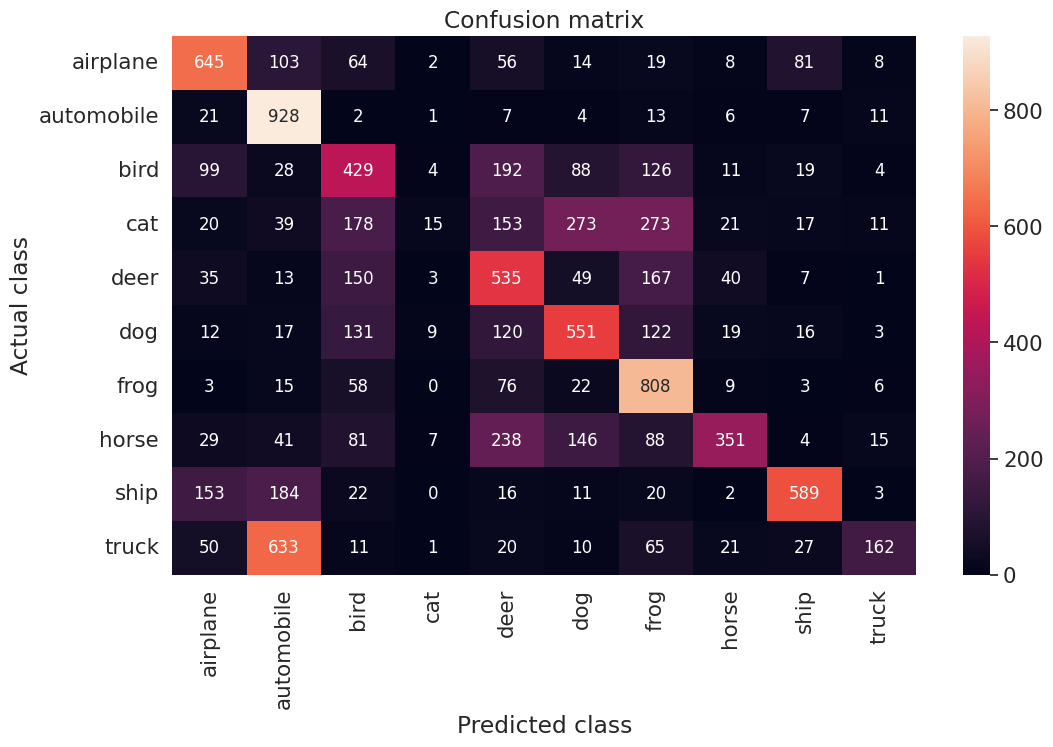


baseline_model_trained_misclassed_worstclass_highprob 0.5397
baseline_model_trained_misclassed_worstclass_highprob [0.469 0.661 0.354 0.47  0.531 0.505 0.607 0.641 0.595 0.564]


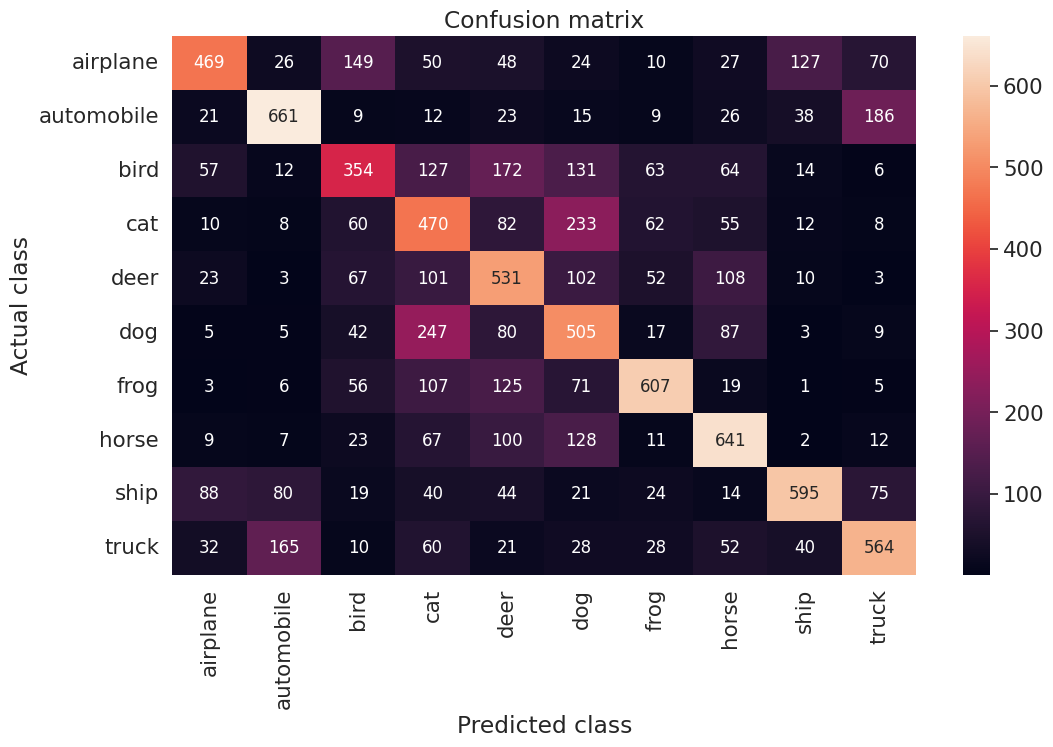


model_trained_by_least_margin_sampling_method 0.5042
model_trained_by_least_margin_sampling_method [0.683 0.831 0.403 0.024 0.571 0.592 0.801 0.269 0.717 0.151]


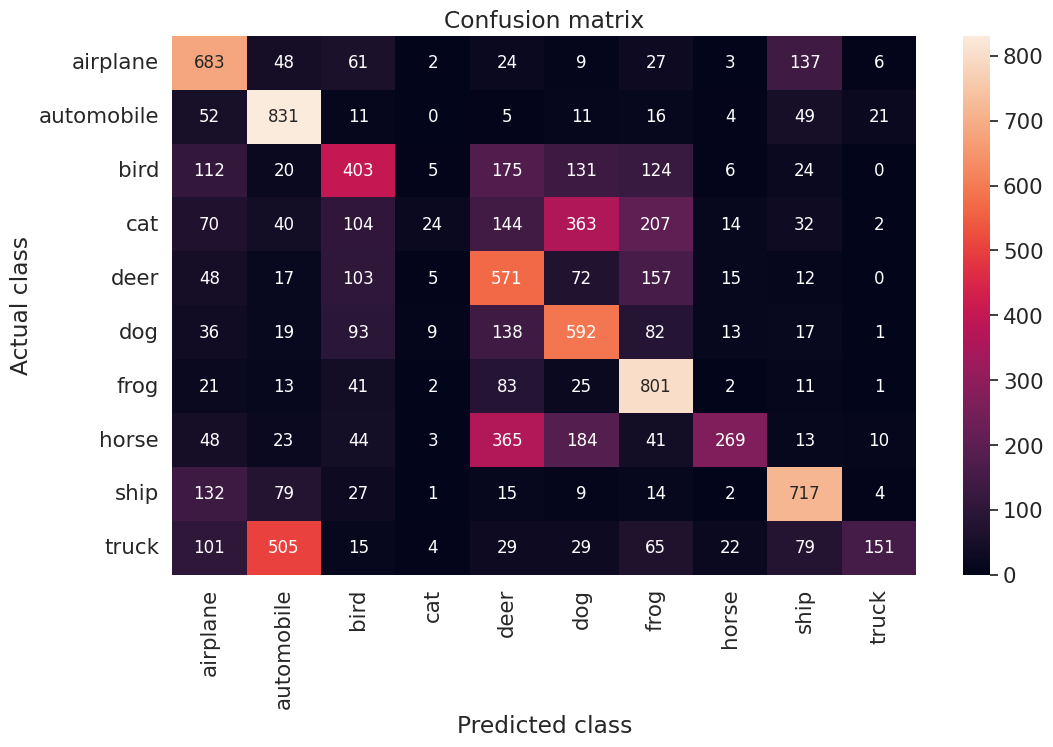


model_trained_by_uncertainty_method 0.5001
model_trained_by_uncertainty_method [0.672 0.675 0.277 0.041 0.571 0.626 0.869 0.19  0.641 0.439]


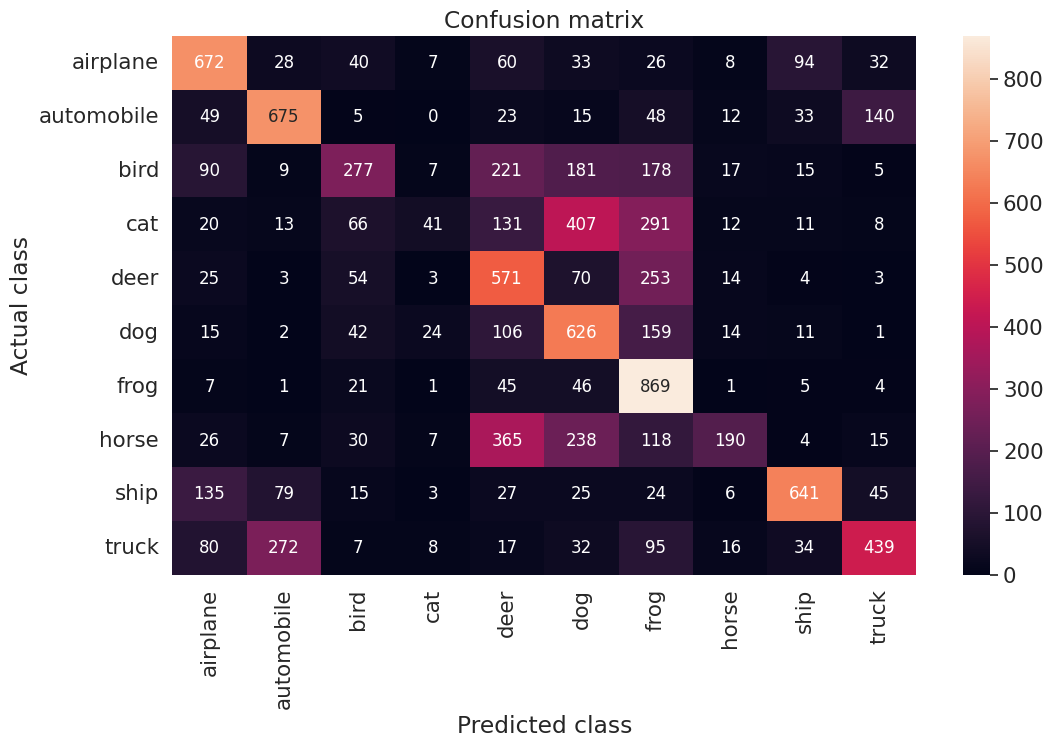


baseline_model_randomly_sampled_pool 0.5055
baseline_model_randomly_sampled_pool [0.61  0.738 0.42  0.037 0.563 0.64  0.797 0.333 0.613 0.304]


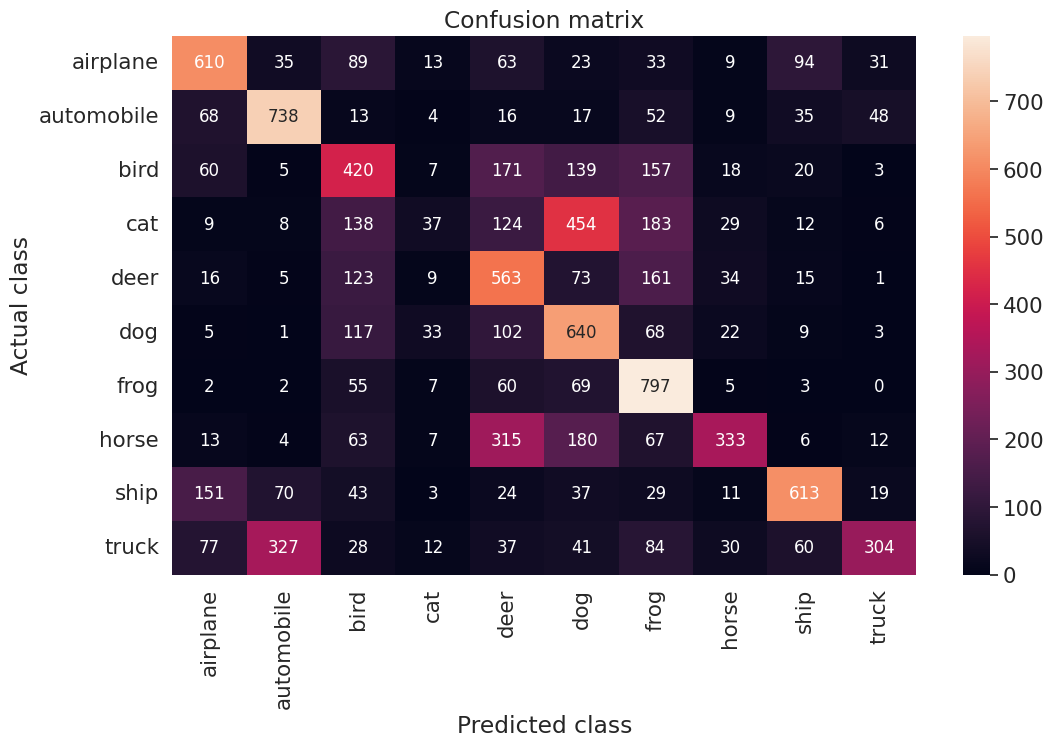


model_trained_by_kmeans_clustered_distant_sampling 0.5063
model_trained_by_kmeans_clustered_distant_sampling [0.558 0.811 0.379 0.042 0.726 0.538 0.751 0.188 0.786 0.284]


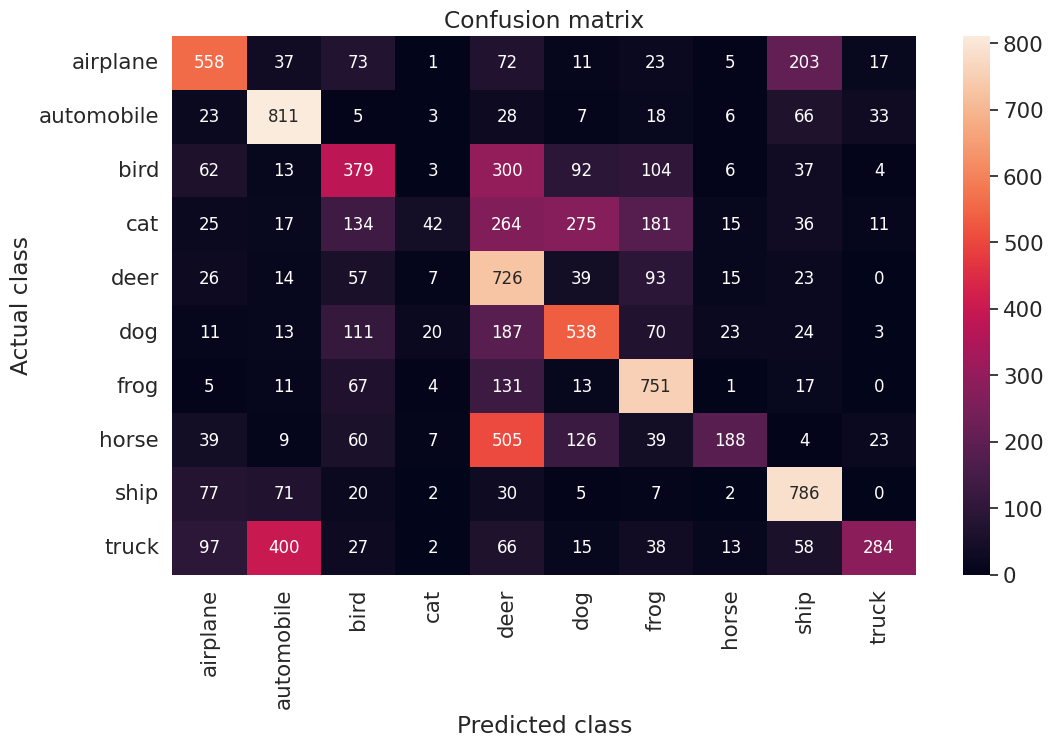


model_trained_by_kmeans_clustered_distant_by_cluster_sampling 0.4926
model_trained_by_kmeans_clustered_distant_by_cluster_sampling [0.59  0.806 0.293 0.04  0.634 0.618 0.793 0.226 0.785 0.141]


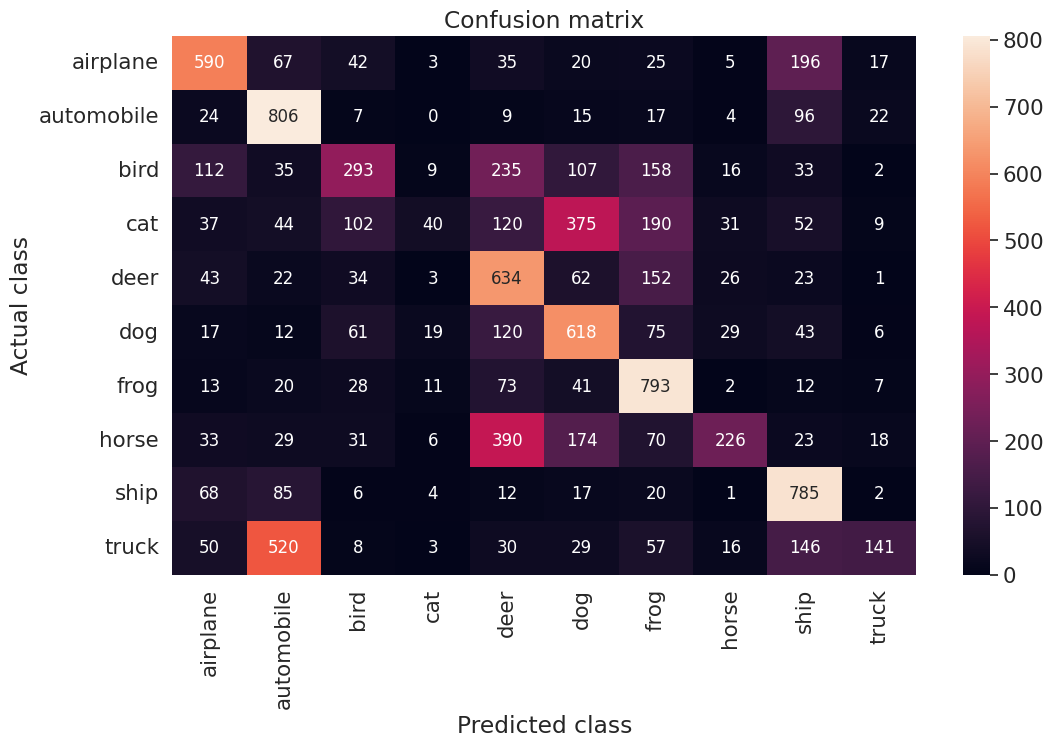


baseline_model_trained_on_init_data 0.4448
baseline_model_trained_on_init_data [0.632 0.636 0.324 0.007 0.455 0.564 0.816 0.157 0.628 0.229]


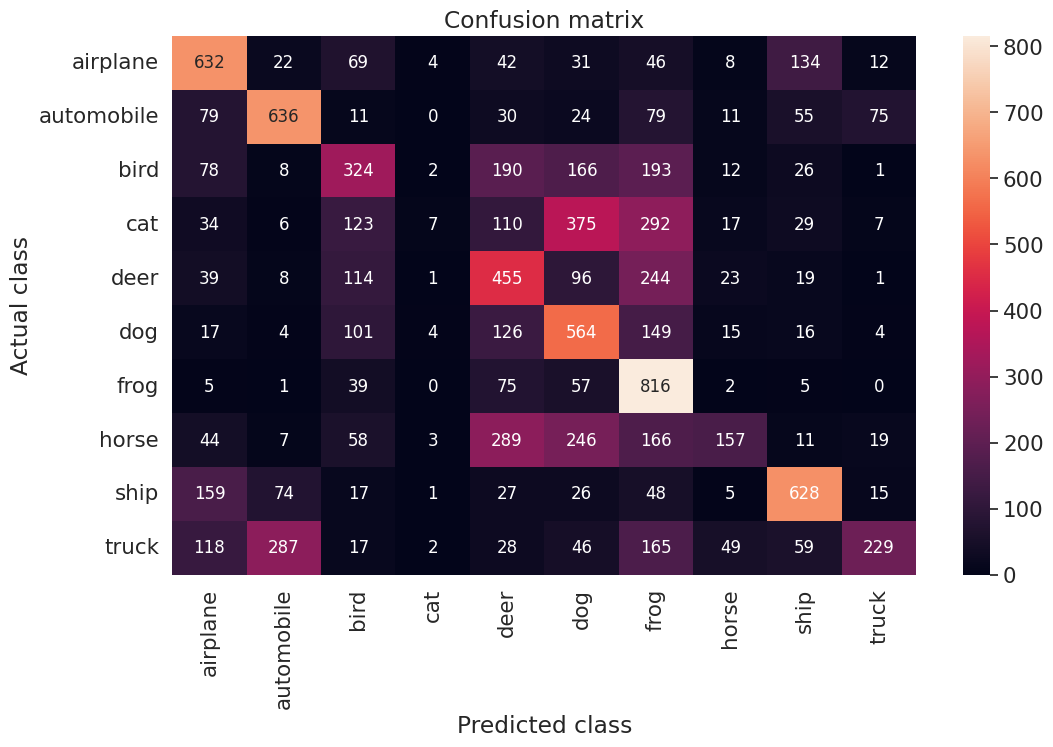


baseline_model_trained_misclassed_worstclass_highmargin 0.5481
baseline_model_trained_misclassed_worstclass_highmargin [0.546 0.643 0.405 0.428 0.361 0.365 0.784 0.561 0.733 0.655]


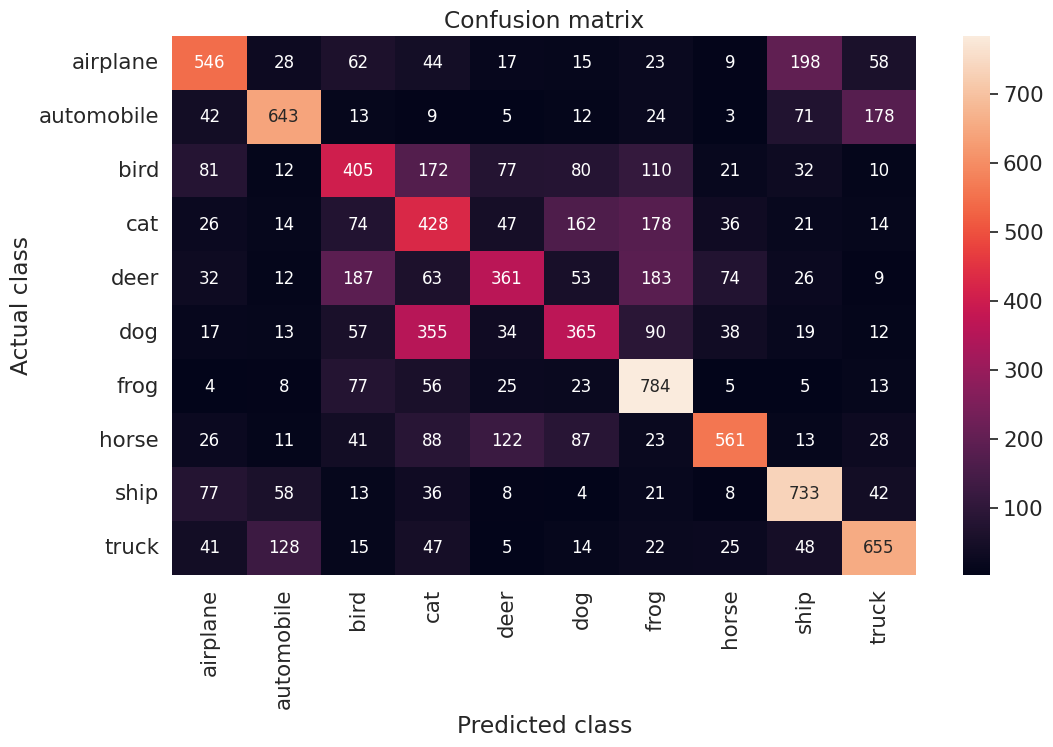


model_trained_by_knn_cnn_voting_misclassed_sampling 0.526
model_trained_by_knn_cnn_voting_misclassed_sampling [0.63  0.805 0.522 0.013 0.587 0.667 0.813 0.294 0.715 0.214]


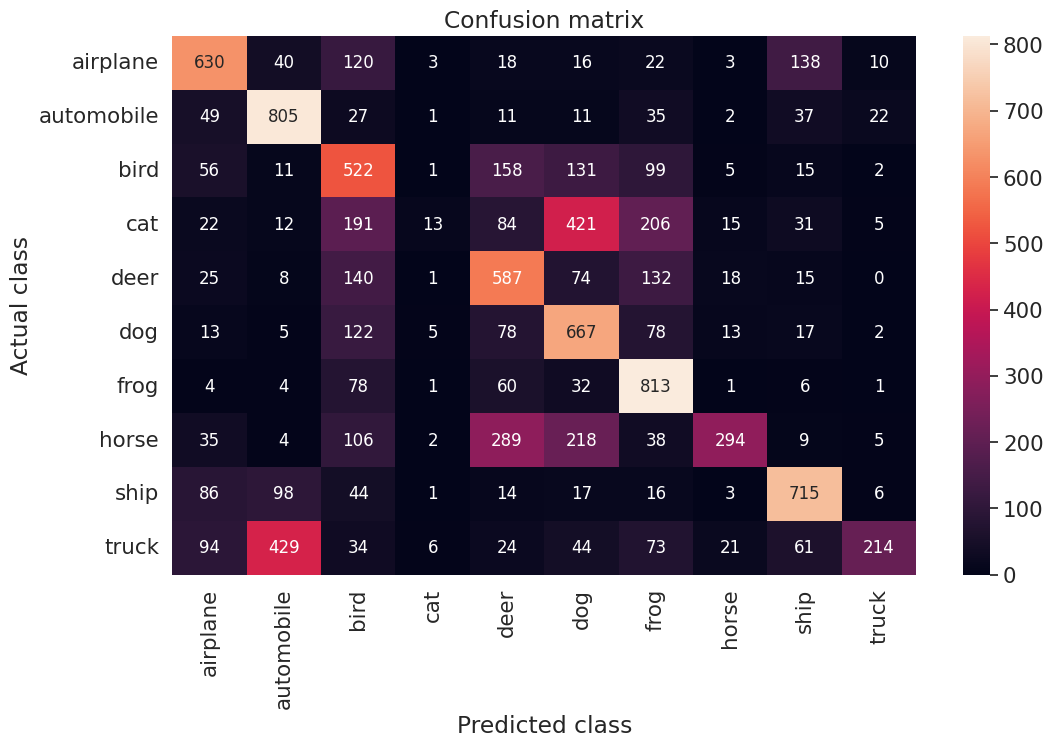


baseline_model_trained_on_all 0.7896
baseline_model_trained_on_all [0.831 0.931 0.716 0.352 0.855 0.863 0.893 0.712 0.902 0.841]


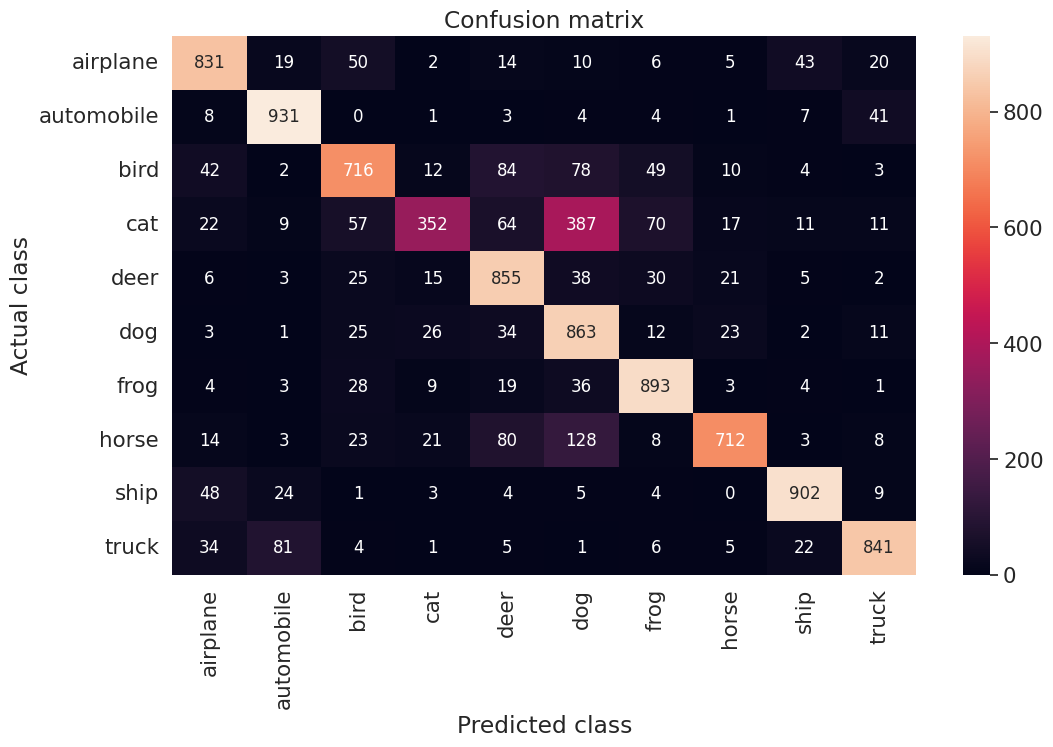


baseline_model_trained_misclassed_worstclass_lowentropy 0.54
baseline_model_trained_misclassed_worstclass_lowentropy [0.575 0.683 0.483 0.461 0.448 0.362 0.769 0.364 0.58  0.675]


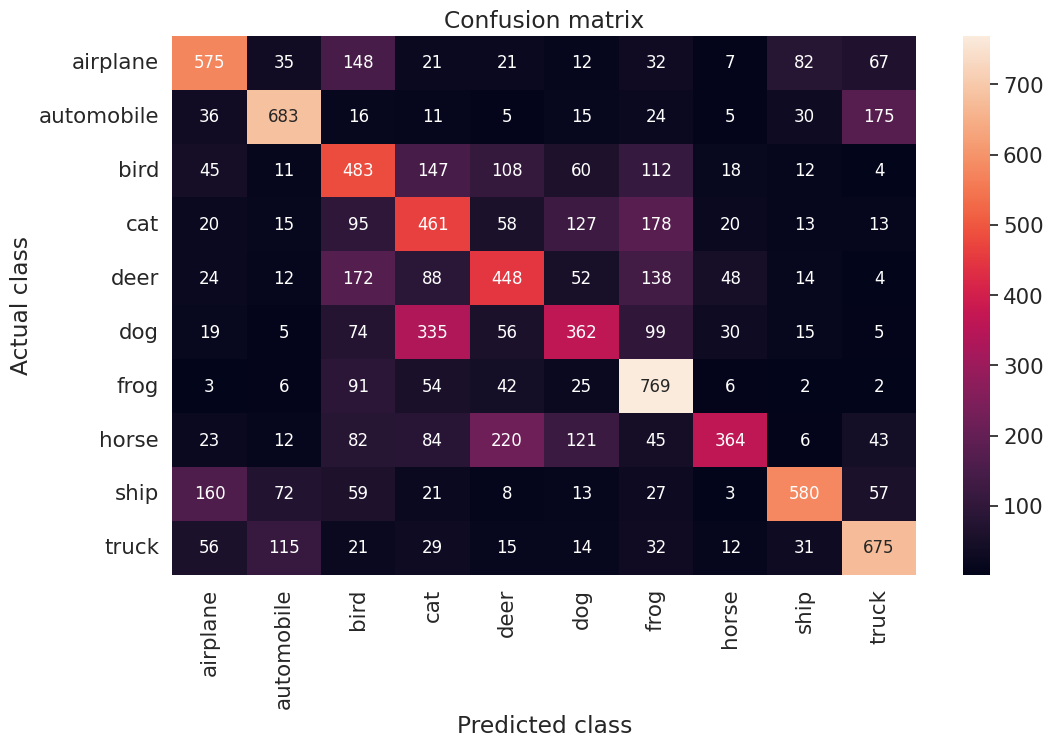

In [44]:
from pathlib import Path
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


data = utils.get_data()
test_x, test_y = data['test']
prep_test_x, prep_test_y = utils.prepare_data(test_x, test_y)

trained_models_root_folder = 'trained_models'

for model_path in Path(trained_models_root_folder).glob('*.keras'):
    model_name = model_path.stem

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    model = load_model(model_path.as_posix())
    model_stat = utils.model_stats(model,prep_test_x, test_y)
    print(model_name, model_stat['accuracy_score'])
    print(model_name, model_stat['categorical_accuracy_scores'])

    df_cm = pd.DataFrame(model_stat['confusion_matrix'], class_names,class_names)
    plt.figure(figsize=(12,7))
    ax = plt.axes()
    sn.set(font_scale=1.4)
    
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 12}, ax=ax,fmt='g')
    ax.set_title('Confusion matrix')
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('Actual class')
    
    plt.savefig(Path(f'trained_models/plots/{model_name}_conf_mat.png').as_posix(),bbox_inches='tight')
    plt.show()
    print()
    

Plot history of networks


trained_models/model_trained_by_least_margin_sampling_method.pickle


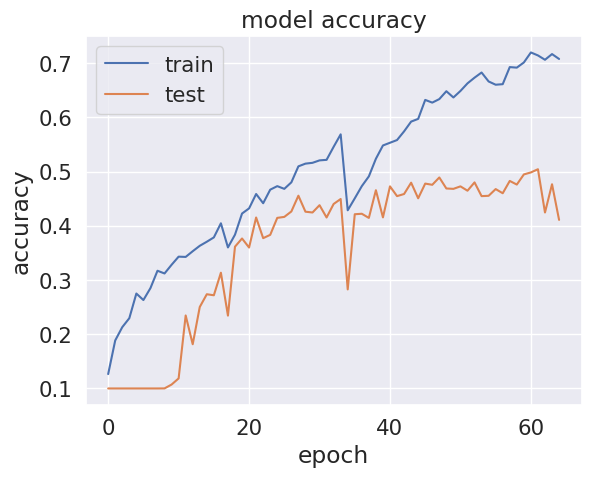

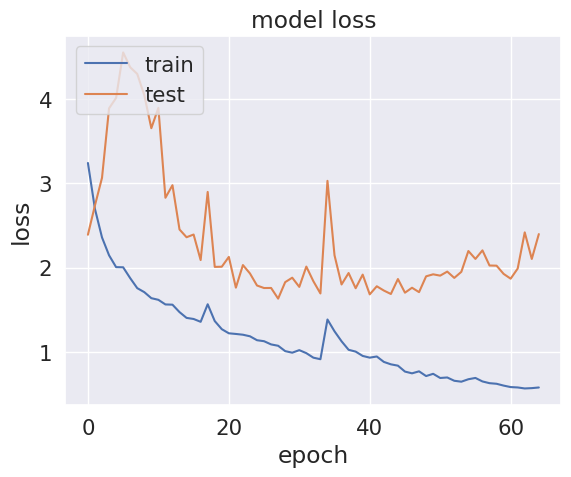

trained_models/model_trained_by_uncertainty_method.pickle


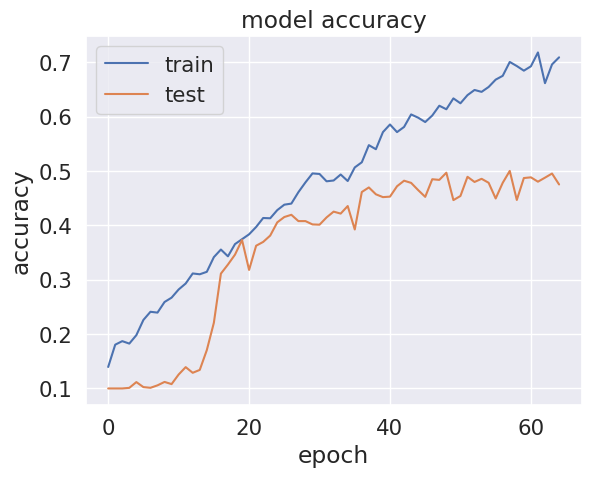

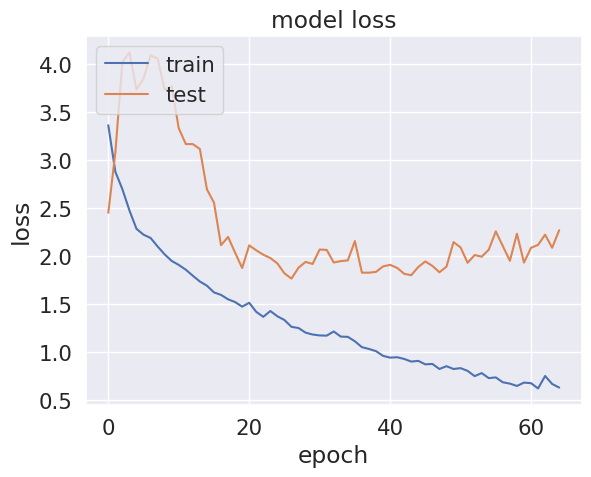

trained_models/model_trained_by_kmeans_clustered_distant_by_cluster_sampling.pickle


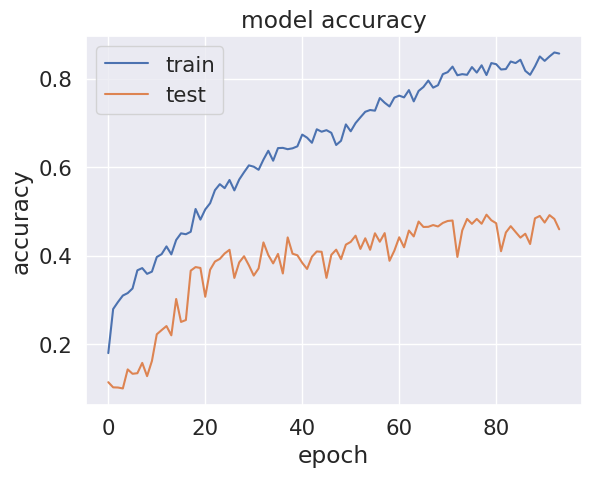

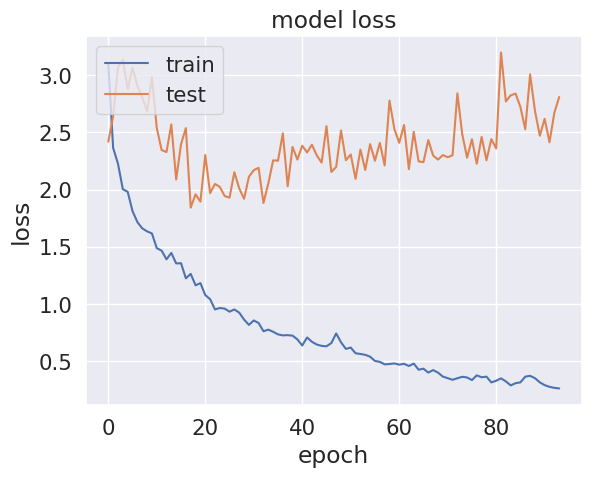

trained_models/model_trained_by_highest_entropy_sampling_method.pickle


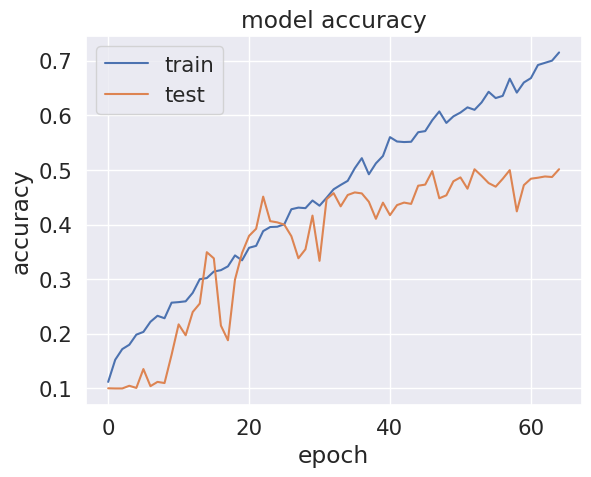

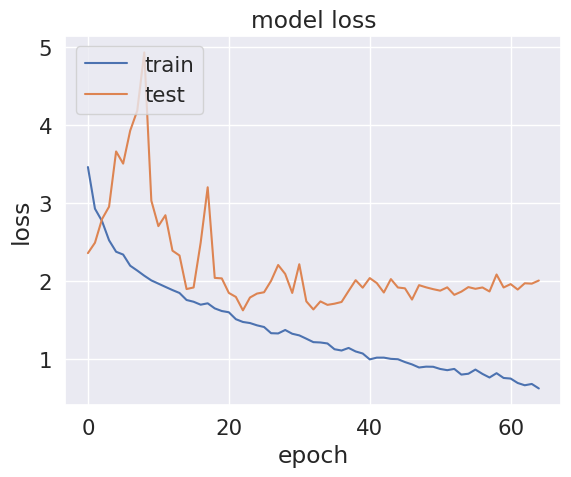

trained_models/baseline_model_trained_on_all.pickle


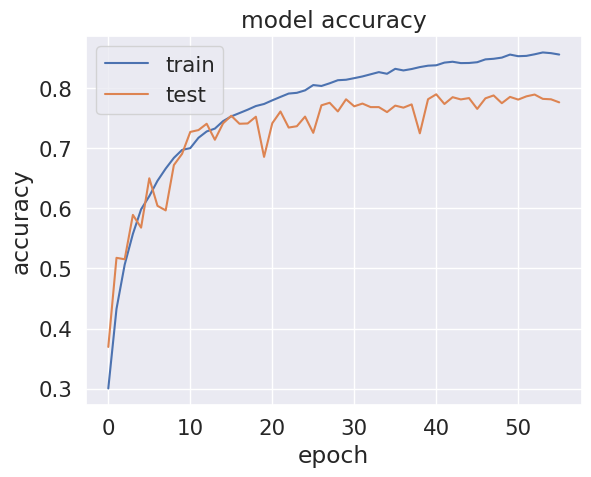

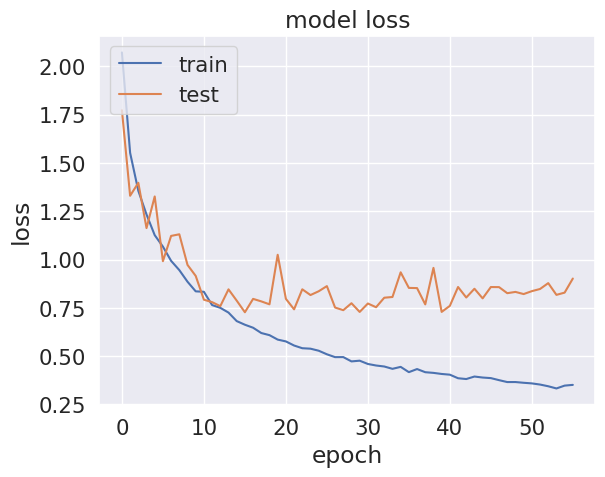

trained_models/model_trained_by_knn_cnn_voting_misclassed_sampling.pickle


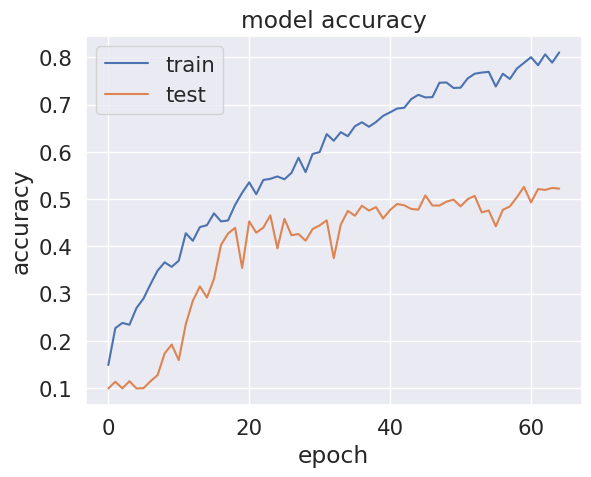

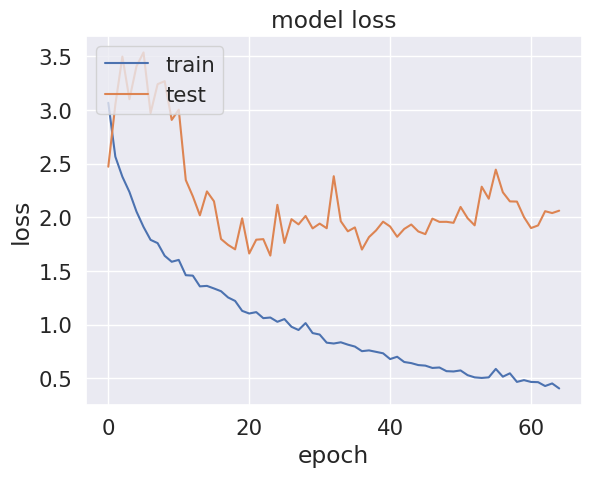

trained_models/baseline_model_trained_misclassed_worstclass_lowentropy.pickle


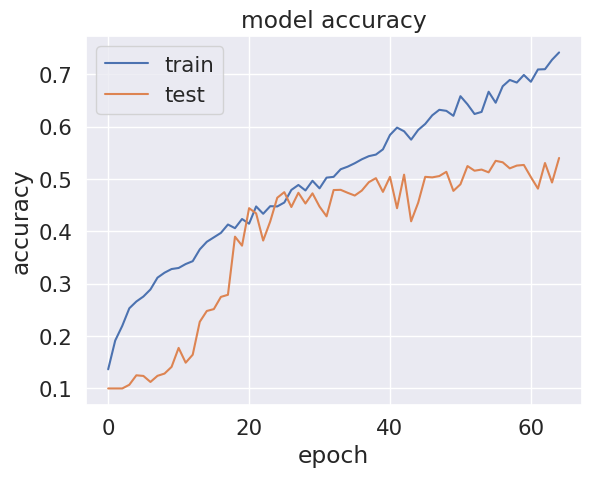

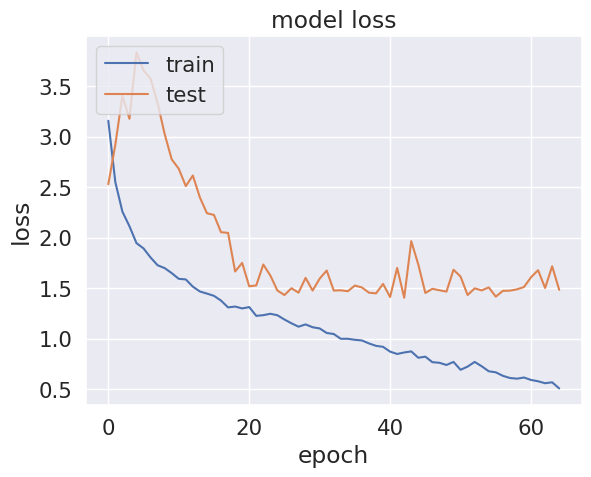

trained_models/baseline_model_randomly_sampled_pool.pickle


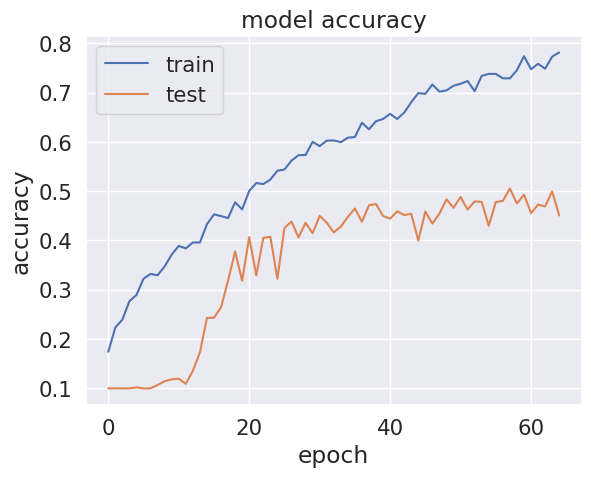

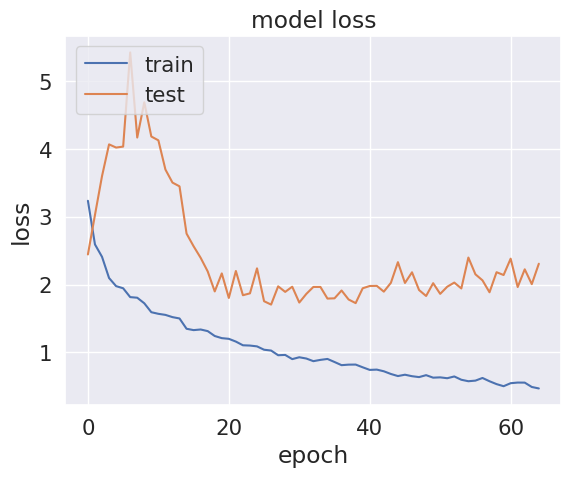

trained_models/baseline_model_trained_misclassed_worstclass_highprob.pickle


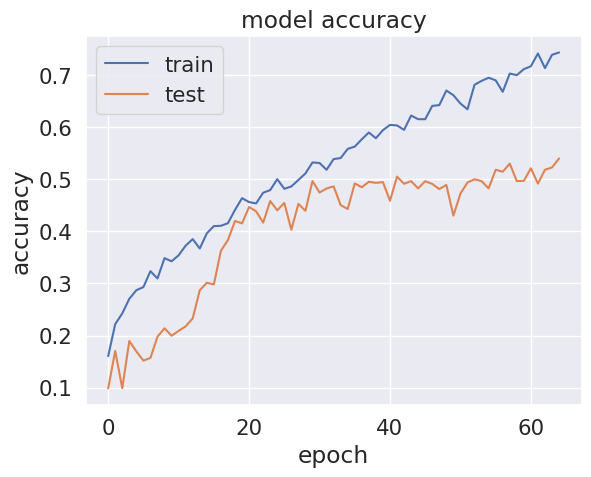

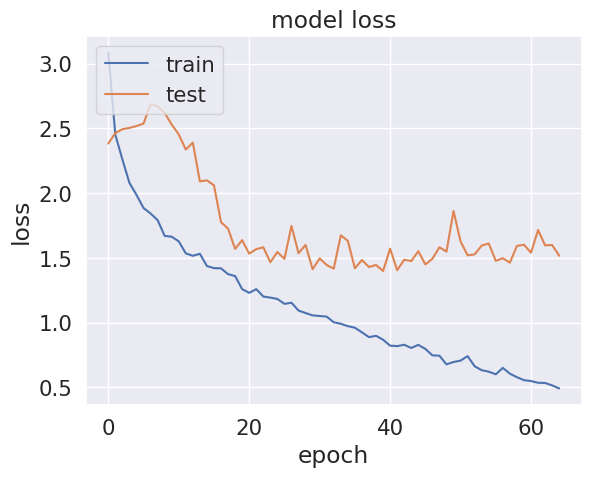

trained_models/baseline_model_trained_on_init_data.pickle


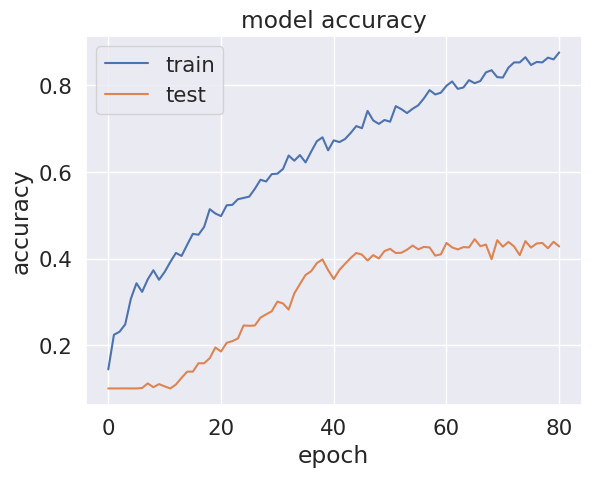

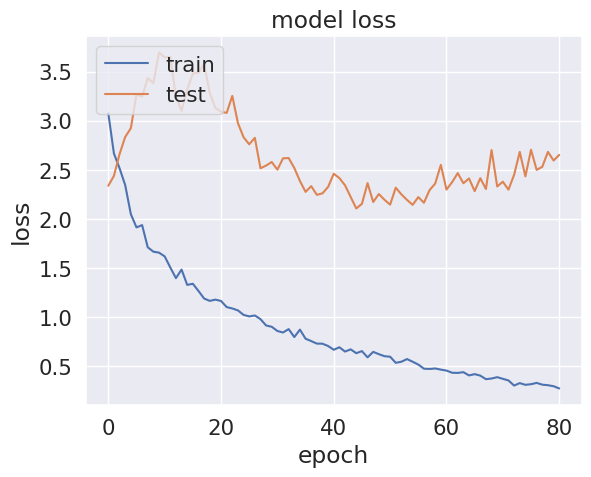

trained_models/baseline_model_trained_misclassed_worstclass_highmargin.pickle


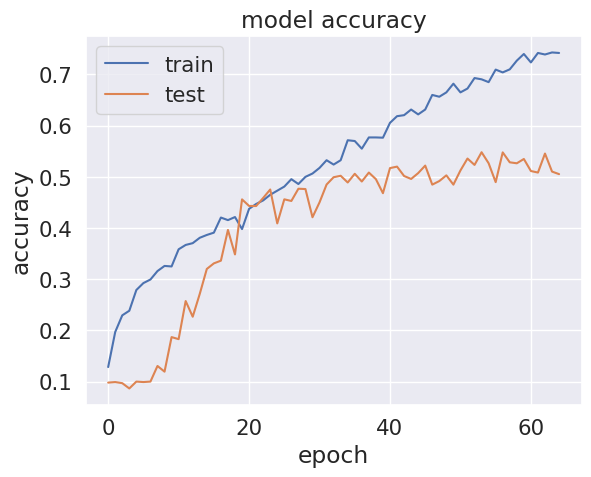

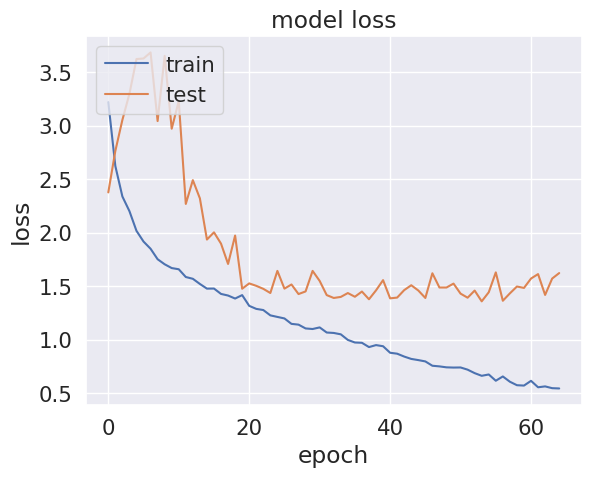

trained_models/model_trained_by_kmeans_clustered_distant_sampling.pickle


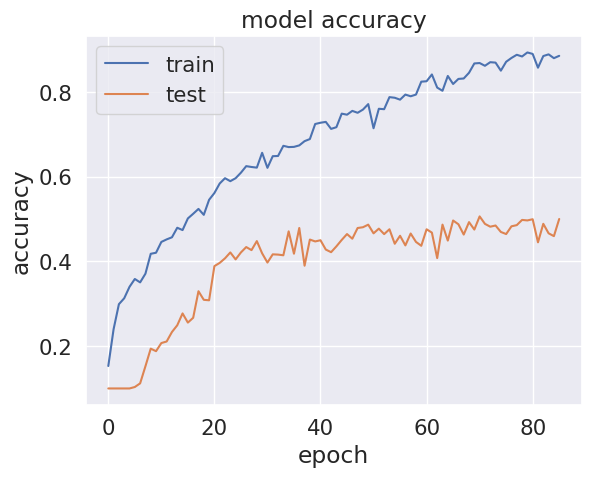

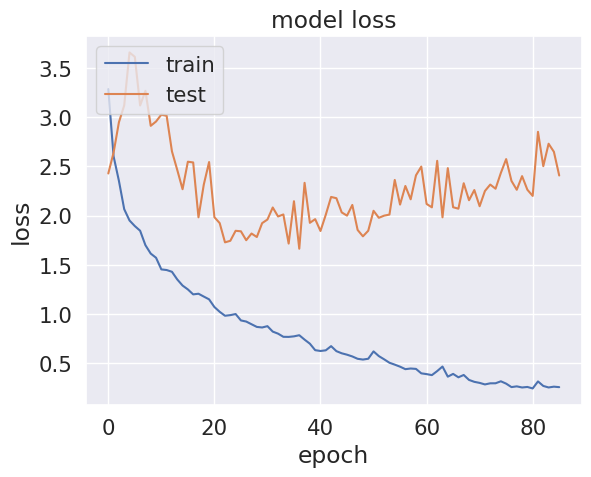

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pickle

trained_models_root_folder = 'trained_models'

for model_path in Path(trained_models_root_folder).glob('*.pickle'):

    history = pickle.load(open(model_path.as_posix(),'rb'))
    print(model_path)
    
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(Path(f'trained_models/plots/{model_path.stem}_acc_plot.png').as_posix(),bbox_inches='tight')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(Path(f'trained_models/plots/{model_path.stem}_loss_plot.png').as_posix(),bbox_inches='tight')
    plt.show()
    